# PARTE A

In [33]:
# LIBRERIAS

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [34]:
# MOSTRAR LA IMAGEN, PLOTEO.
def mostrar_imagen(imagen, titulo="Imagen"):
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    else:
        imagen_rgb = imagen  
    plt.figure(figsize=(10, 8))
    plt.title(titulo)
    plt.imshow(imagen_rgb, cmap='gray' if len(imagen.shape) == 2 else None)
    plt.axis('off')
    plt.show()


In [35]:

# OBTENER IMAGEN BINARIA
def obtener_imagen_binaria(imagen, umbral=200):
    """
    Convierte una imagen a binaria utilizando un umbral.
    """

    # Convierte a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Genera la imagen binaria con el umbral seleccionado
    _, binaria = cv2.threshold(gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    return binaria

In [36]:
# DETECTAR CIRCULOS EN UNA IMAGEN BINARIA
def detectar_circulos(imagen_binaria, min_circularidad=0.7, min_ancho=15, max_ancho=40, min_alto=15, max_alto=40):
    """
    Detecta circulos dentro de una imagen binaria.
    Los argumentos permiten determinar lo que se define como circulo.
        
    Devuelve una lista de los circulos detectados en la imagen.
    """
    # Obtiene los contornos de la imagen binaria
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circulos = []
    
    # Procesa cada contorno
    for contorno in contornos:
        # Calcula area y perimetro
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        
        # Calcula la circularidad del contorno
        if perimetro > 0:
            circularidad = 4 * np.pi * area / (perimetro * perimetro)
            
            if circularidad > min_circularidad:
                x, y, w, h = cv2.boundingRect(contorno)
                if min_ancho < w < max_ancho and min_alto < h < max_alto:
                    centro_x = x + w//2
                    centro_y = y + h//2
                    radio = max(w, h) // 2
                    circulos.append((centro_x, centro_y, radio, contorno))
    
    return circulos


In [37]:

# VISUALIZAR LOS CIRCULOS
def visualizar_circulos(imagen_original, circulos):
    """
    Crea una visualizacion de los circulos detectados sobre la imagen original.
    """

    imagen_con_circulos = imagen_original.copy()
    
    # Dibuja cada circulo encontrado
    for cx, cy, r, _ in circulos:
        cv2.circle(imagen_con_circulos, (cx, cy), r, (0, 255, 0), 2)
        cv2.circle(imagen_con_circulos, (cx, cy), 2, (0, 0, 255), -1)  # Center point
    
    return imagen_con_circulos

In [38]:
# AGRUPAR CIRCULOS EN GRUPOS DE 5
def agrupar_circulos_en_preguntas(circulos, tolerancia_y=15):
    """
    Agrupa los circulos en grupos de a 5, lo que corresponde a las opciones de respuesta (A, B, C, D, E).
    """
    if not circulos:
        return {}
    
    # Ordena los circulos segun su eje Y
    circulos_ordenados = sorted(circulos, key=lambda c: c[1])
    
    # Los agrupa en las filas correspondientes
    filas = []
    fila_actual = [circulos_ordenados[0]]
    y_actual = circulos_ordenados[0][1]
    
    for circulo in circulos_ordenados[1:]:
        if abs(circulo[1] - y_actual) <= tolerancia_y:
            # Same row
            fila_actual.append(circulo)
        else:
            # New row
            if len(fila_actual) > 0:
                filas.append(fila_actual)
            fila_actual = [circulo]
            y_actual = circulo[1]
    
    # Agrega la fila si no es vacia
    if len(fila_actual) > 0:
        filas.append(fila_actual)
    
    # Ordena cada fila segun su eje X
    for i in range(len(filas)):
        filas[i] = sorted(filas[i], key=lambda c: c[0])
    
    # Crea el diccionario de preguntas
    preguntas = {}
    for i, fila in enumerate(filas):
        if len(fila) == 5:  
            preguntas[i + 1] = fila 
    
    return preguntas


In [39]:

# VISUALIZAR LAS PREGUNTAS
def visualizar_preguntas(imagen_original, preguntas):
    """
    Visualiza las preguntas en la imagen original.
    """
    
    imagen_con_preguntas = imagen_original.copy()
    
    colores = [
        (255, 0, 0),    # Blue
        (0, 255, 0),    # Green
        (0, 0, 255),    # Red
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
        (128, 0, 0),    # Dark blue
        (0, 128, 0),    # Dark green
        (0, 0, 128),    # Dark red
        (128, 128, 0),  # Dark cyan
    ]
    
    # Dibuja las preguntas con diferentes colores
    for num_pregunta, circulos in preguntas.items():
        color = colores[(num_pregunta - 1) % len(colores)]
        
        # Dibuja el circulo en cada pregunta
        for i, (cx, cy, r, _) in enumerate(circulos):
            cv2.circle(imagen_con_preguntas, (cx, cy), r, color, 2)
            opcion = chr(65 + i)  
            cv2.putText(imagen_con_preguntas, f"{num_pregunta}-{opcion}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_preguntas

In [40]:
# Detectar respuesta seleccionada
def detectar_circulos_marcados(imagen, preguntas, umbral_marcado=150):
    """
    Determina cual fue la respuesta que se selecciono en cada pregunta
    """
    # Convierte la imagen a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    respuestas = {}
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    # Analisis de cada pregunta
    for num_pregunta, circulos in preguntas.items():
        respuestas[num_pregunta] = []
        
        # Analisis de cada opcion en la pregunta
        for i, (cx, cy, r, _) in enumerate(circulos):
            # Crea una mascara para el circulo actual
            mask = np.zeros(gris.shape, dtype=np.uint8)
            cv2.circle(mask, (cx, cy), r, 255, -1)
            
            # Calcula la intensidad media de la mascara en la imagen gris
            mean_val = cv2.mean(gris, mask=mask)[0]
            
            # Si la media esta por debajo del umbral, significa que esta marcada
            if mean_val < umbral_marcado:
                respuestas[num_pregunta].append(opciones[i])
    
    return respuestas


In [41]:
# VISUALIZAR RESPUESTAS
def visualizar_respuestas(imagen_original, preguntas, respuestas):
    """
    Crea una visualizacion de las respuestas seleccionadas
    """
    
    imagen_con_respuestas = imagen_original.copy()
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    for num_pregunta, circulos in preguntas.items():
        opciones_marcadas = respuestas.get(num_pregunta, [])
        
        for i, (cx, cy, r, _) in enumerate(circulos):
            is_marked = opciones[i] in opciones_marcadas

            color = (0, 255, 0) if is_marked else (0, 0, 255)  # Green if marked, red if not
            
            cv2.circle(imagen_con_respuestas, (cx, cy), r, color, 2)

            cv2.putText(imagen_con_respuestas, f"{num_pregunta}-{opciones[i]}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_respuestas


In [42]:
# RESPUESTAS CORRECTAS
respuestas_correctas = {
    1: 'A', 2: 'A', 3: 'B', 4: 'A', 5: 'D',
    6: 'B', 7: 'B', 8: 'C', 9: 'B', 10: 'A',
    11: 'D', 12: 'A', 13: 'C', 14: 'C', 15: 'D',
    16: 'B', 17: 'A', 18: 'C', 19: 'C', 20: 'D',
    21: 'B', 22: 'A', 23: 'C', 24: 'C', 25: 'C'
}

In [43]:

# COMPARAR RESPUESTAS
def evaluar_respuestas(respuestas_detectadas, respuestas_correctas):
    """
    Compara las respuestas correctas con las respuestas detectadas.
    """
    correctas = 0
    incorrectas = 0
    no_contestadas = 0
    puntaje = 0
    
    detalles = {}
    
    for num_pregunta, respuesta_correcta in respuestas_correctas.items():
        opciones_marcadas = respuestas_detectadas.get(num_pregunta, [])
        
        if not opciones_marcadas:
            no_contestadas += 1
            resultado = "No contestada"
        elif len(opciones_marcadas) == 1 and opciones_marcadas[0] == respuesta_correcta:
            correctas += 1
            resultado = "Correcta"
            puntaje += 4
        else:
            incorrectas += 1
            resultado = "Incorrecta"
            puntaje -= 0
        
        detalles[num_pregunta] = {
            "respuesta_correcta": respuesta_correcta,
            "respuesta_marcada": opciones_marcadas,
            "resultado": resultado
        }
    
    puntaje = max(0, puntaje)
    
    return {
        "correctas": correctas,
        "incorrectas": incorrectas,
        "no_contestadas": no_contestadas,
        "puntaje": puntaje,
        "puntaje_maximo": len(respuestas_correctas) * 4,
        "detalles": detalles
    }



In [44]:
def ejercicio1():
    resultados_alumnos = {}
    for i in range(1,6):
        print(f"EXAMEN N° {i}")
        ruta_imagen = f"./multiple_choice_{i}.png"
        if not os.path.exists(ruta_imagen):
            print(f"Error: no se encontro imagen {ruta_imagen}")
        else:
            imagen = cv2.imread(ruta_imagen)
            
            if imagen is None:
                print(f"Error:no se pudo leer la imagen {ruta_imagen}")
            else:
                mostrar_imagen(imagen, "Imagen original")
                
                # CONVERTIR A IMAGEN BINARIA
                binaria = obtener_imagen_binaria(imagen)
                mostrar_imagen(binaria, "Imagen binaria")
                
                # DETECTAR LOS CIRCULOS
                circulos_detectados = detectar_circulos(binaria)
                print(f"Detectados {len(circulos_detectados)} circulos")
                
                # AGRUPAR CIRCULOS
                preguntas = agrupar_circulos_en_preguntas(circulos_detectados)
                print(f"Agrupados en {len(preguntas)} preguntas")
                
                # DETECTAR CIRCULOS MARCADOS
                respuestas = detectar_circulos_marcados(imagen, preguntas)
                
                # MOSTRAR RESPUESTAS
                print("\nRespuestas detectadas:")
                for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                    print(f"Pregunta {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'Nula'}")
                
                # VISUALIZAR RESPUESTAS
                imagen_con_respuestas = visualizar_respuestas(imagen, preguntas, respuestas)
                mostrar_imagen(imagen_con_respuestas, "Respuestas Marcadas")

                print("\nDespuestas detectadas:")
                for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                    print(f"Pregunta {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'Nula'}")
                
                # EVALUAR RESPUESTAS
                resultados = evaluar_respuestas(respuestas, respuestas_correctas)
                
                # MOSTRAR RESULTADOS
                print("\nResultados evaluacion:")
                print(f"Respuestas correctas: {resultados['correctas']}")
                print(f"Respuestas incorrectas: {resultados['incorrectas']}")
                print(f"Respuestas nulas: {resultados['no_contestadas']}")
                print(f"Puntaje: {resultados['puntaje']} / {resultados['puntaje_maximo']}")
                
                # RESULTADOS DETALLADOS
                print("\nResultados detallados:")
                for num_pregunta, detalle in sorted(resultados['detalles'].items()):
                    marcada = ', '.join(detalle['respuesta_marcada']) if detalle['respuesta_marcada'] else 'None'
                    print(f"Pregunta {num_pregunta}: Correcta={detalle['respuesta_correcta']}, Marcada={marcada}, Resultado={detalle['resultado']}")
            resultados_alumnos[f"examen{i}"] = resultados['correctas']
    return resultados_alumnos                

EXAMEN N° 1


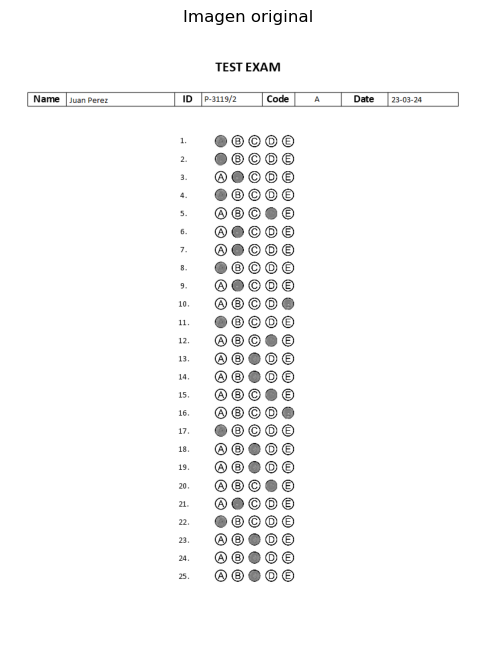

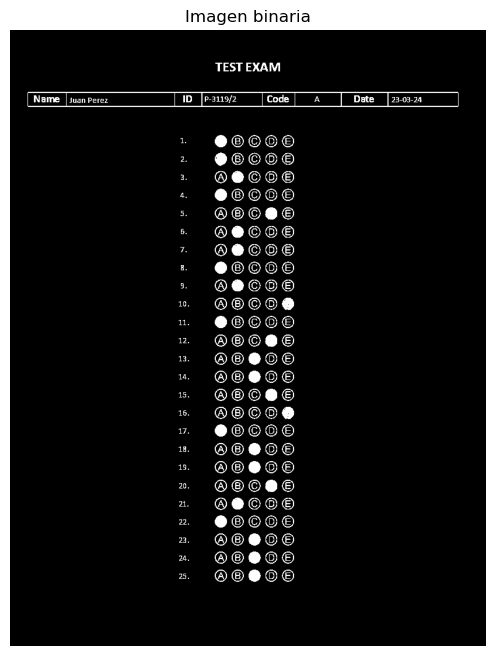

Detectados 125 circulos
Agrupados en 25 preguntas

Respuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: A
Pregunta 5: D
Pregunta 6: B
Pregunta 7: B
Pregunta 8: A
Pregunta 9: B
Pregunta 10: E
Pregunta 11: A
Pregunta 12: D
Pregunta 13: C
Pregunta 14: C
Pregunta 15: D
Pregunta 16: E
Pregunta 17: A
Pregunta 18: C
Pregunta 19: C
Pregunta 20: D
Pregunta 21: B
Pregunta 22: A
Pregunta 23: C
Pregunta 24: C
Pregunta 25: C


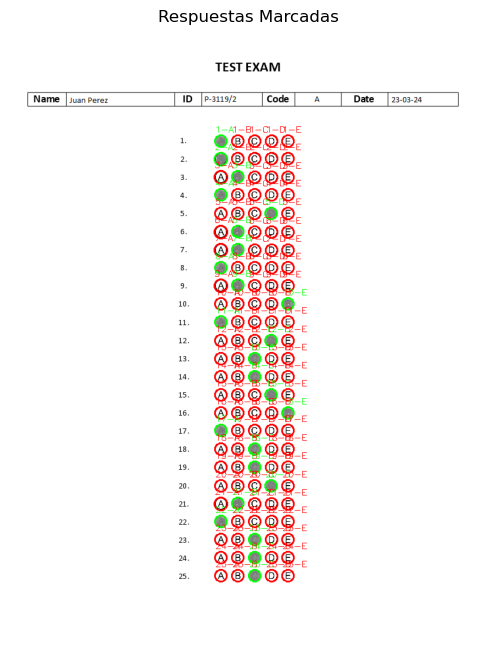


Despuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: A
Pregunta 5: D
Pregunta 6: B
Pregunta 7: B
Pregunta 8: A
Pregunta 9: B
Pregunta 10: E
Pregunta 11: A
Pregunta 12: D
Pregunta 13: C
Pregunta 14: C
Pregunta 15: D
Pregunta 16: E
Pregunta 17: A
Pregunta 18: C
Pregunta 19: C
Pregunta 20: D
Pregunta 21: B
Pregunta 22: A
Pregunta 23: C
Pregunta 24: C
Pregunta 25: C

Resultados evaluacion:
Respuestas correctas: 20
Respuestas incorrectas: 5
Respuestas nulas: 0
Puntaje: 80 / 100

Resultados detallados:
Pregunta 1: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 2: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 3: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 4: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 5: Correcta=D, Marcada=D, Resultado=Correcta
Pregunta 6: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 7: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 8: Correcta=C, Marcada=A, Resultado=Incorrecta
Pregunta 9: Correcta=B, Marcada=B, Resu

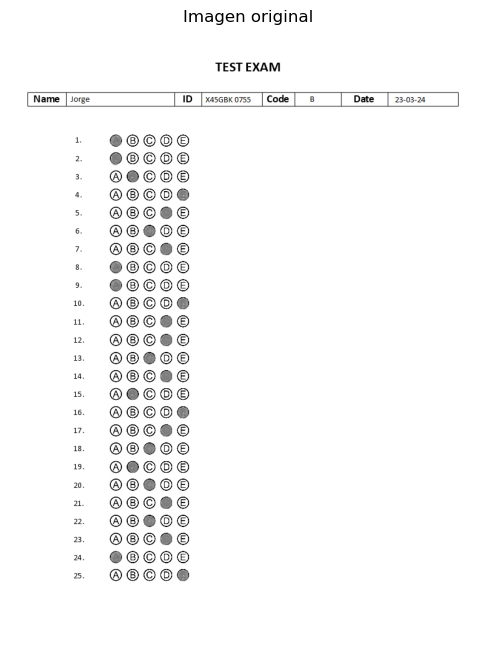

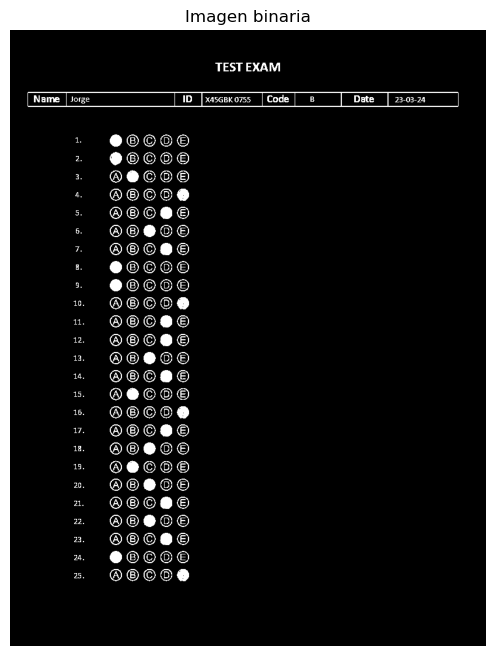

Detectados 125 circulos
Agrupados en 25 preguntas

Respuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: D
Pregunta 6: C
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: D
Pregunta 12: D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: C
Pregunta 19: B
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: D
Pregunta 24: A
Pregunta 25: E


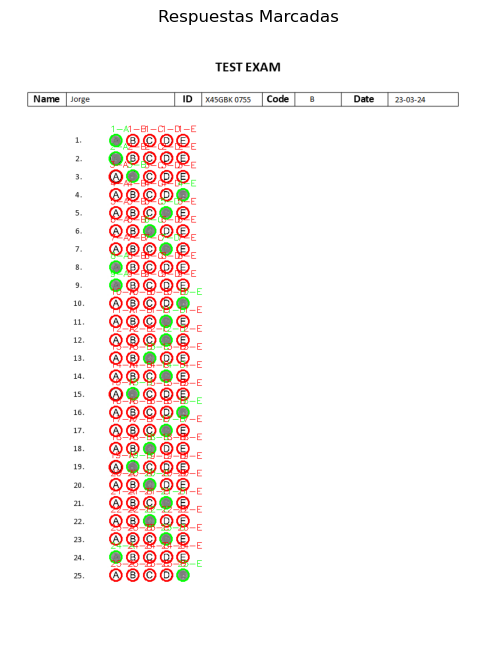


Despuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: D
Pregunta 6: C
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: D
Pregunta 12: D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: C
Pregunta 19: B
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: D
Pregunta 24: A
Pregunta 25: E

Resultados evaluacion:
Respuestas correctas: 7
Respuestas incorrectas: 18
Respuestas nulas: 0
Puntaje: 28 / 100

Resultados detallados:
Pregunta 1: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 2: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 3: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 4: Correcta=A, Marcada=E, Resultado=Incorrecta
Pregunta 5: Correcta=D, Marcada=D, Resultado=Correcta
Pregunta 6: Correcta=B, Marcada=C, Resultado=Incorrecta
Pregunta 7: Correcta=B, Marcada=D, Resultado=Incorrecta
Pregunta 8: Correcta=C, Marcada=A, Resultado=Incorrecta
Pregunta 9: Correcta=B, Marcada=A

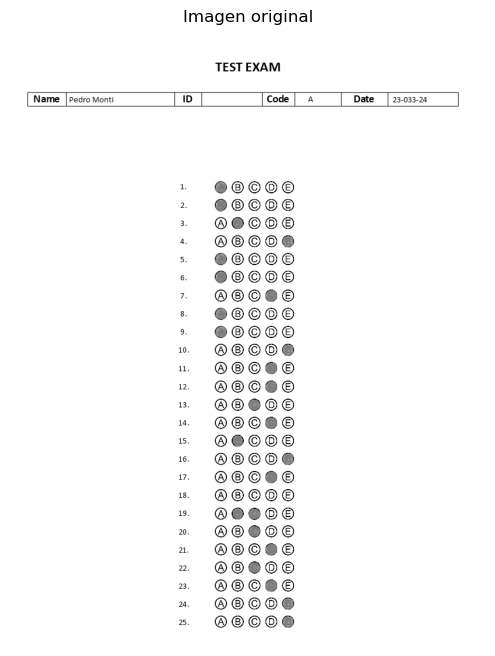

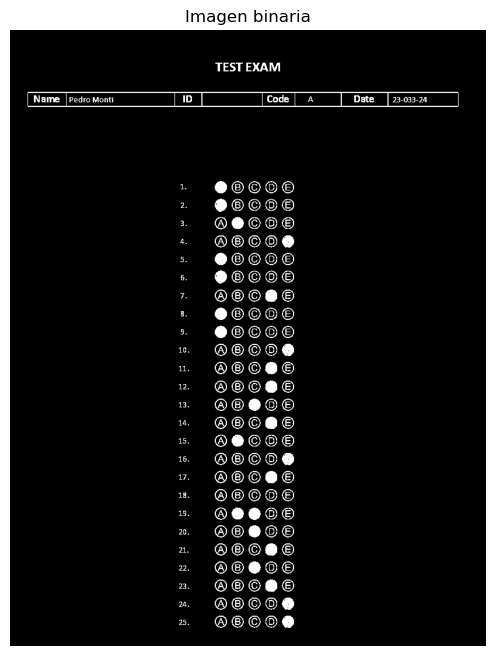

Detectados 125 circulos
Agrupados en 25 preguntas

Respuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: A
Pregunta 6: A
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: D
Pregunta 12: D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: Nula
Pregunta 19: B, C
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: D
Pregunta 24: E
Pregunta 25: E


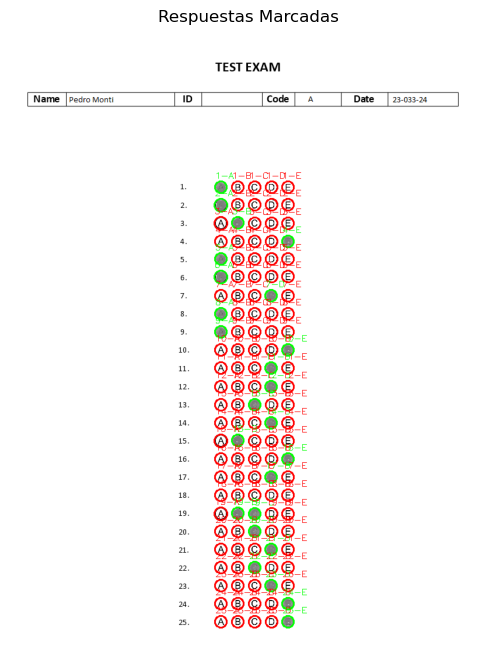


Despuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: A
Pregunta 6: A
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: D
Pregunta 12: D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: Nula
Pregunta 19: B, C
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: D
Pregunta 24: E
Pregunta 25: E

Resultados evaluacion:
Respuestas correctas: 5
Respuestas incorrectas: 19
Respuestas nulas: 1
Puntaje: 20 / 100

Resultados detallados:
Pregunta 1: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 2: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 3: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 4: Correcta=A, Marcada=E, Resultado=Incorrecta
Pregunta 5: Correcta=D, Marcada=A, Resultado=Incorrecta
Pregunta 6: Correcta=B, Marcada=A, Resultado=Incorrecta
Pregunta 7: Correcta=B, Marcada=D, Resultado=Incorrecta
Pregunta 8: Correcta=C, Marcada=A, Resultado=Incorrecta
Pregunta 9: Correcta=B, M

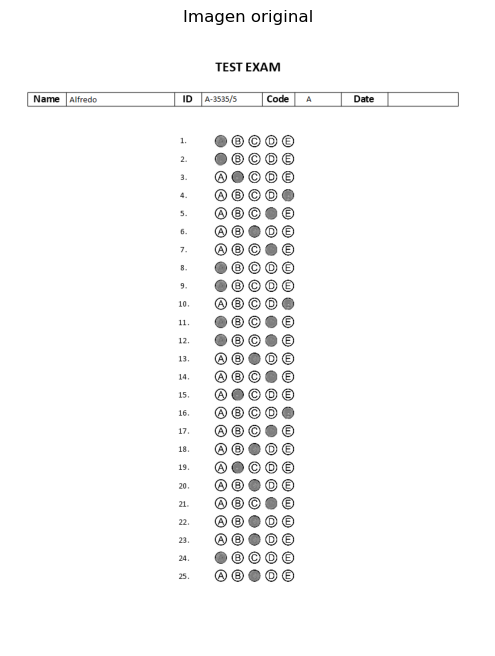

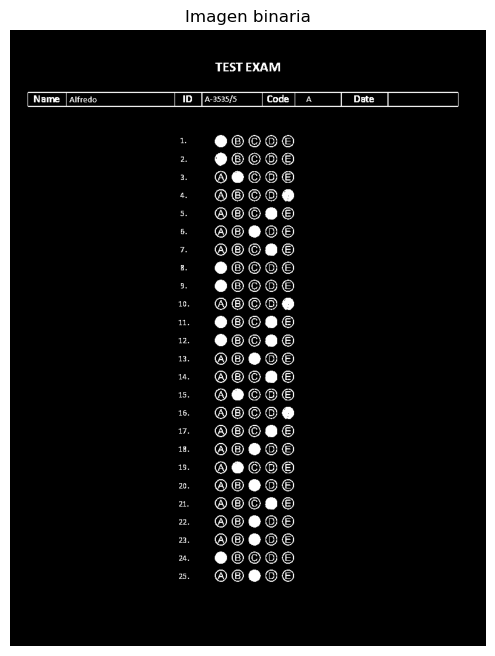

Detectados 125 circulos
Agrupados en 25 preguntas

Respuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: D
Pregunta 6: C
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: A, D
Pregunta 12: A, D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: C
Pregunta 19: B
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: C
Pregunta 24: A
Pregunta 25: C


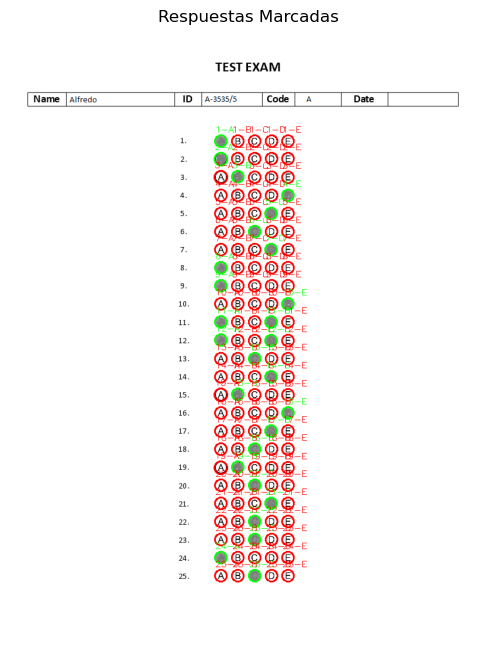


Despuestas detectadas:
Pregunta 1: A
Pregunta 2: A
Pregunta 3: B
Pregunta 4: E
Pregunta 5: D
Pregunta 6: C
Pregunta 7: D
Pregunta 8: A
Pregunta 9: A
Pregunta 10: E
Pregunta 11: A, D
Pregunta 12: A, D
Pregunta 13: C
Pregunta 14: D
Pregunta 15: B
Pregunta 16: E
Pregunta 17: D
Pregunta 18: C
Pregunta 19: B
Pregunta 20: C
Pregunta 21: D
Pregunta 22: C
Pregunta 23: C
Pregunta 24: A
Pregunta 25: C

Resultados evaluacion:
Respuestas correctas: 8
Respuestas incorrectas: 17
Respuestas nulas: 0
Puntaje: 32 / 100

Resultados detallados:
Pregunta 1: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 2: Correcta=A, Marcada=A, Resultado=Correcta
Pregunta 3: Correcta=B, Marcada=B, Resultado=Correcta
Pregunta 4: Correcta=A, Marcada=E, Resultado=Incorrecta
Pregunta 5: Correcta=D, Marcada=D, Resultado=Correcta
Pregunta 6: Correcta=B, Marcada=C, Resultado=Incorrecta
Pregunta 7: Correcta=B, Marcada=D, Resultado=Incorrecta
Pregunta 8: Correcta=C, Marcada=A, Resultado=Incorrecta
Pregunta 9: Correcta=B, Mar

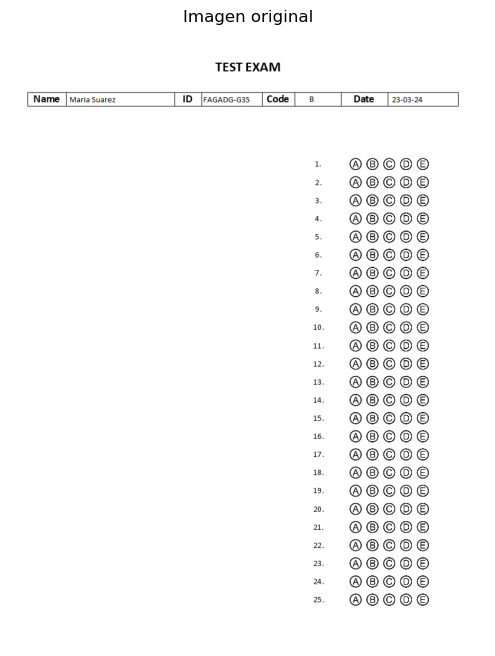

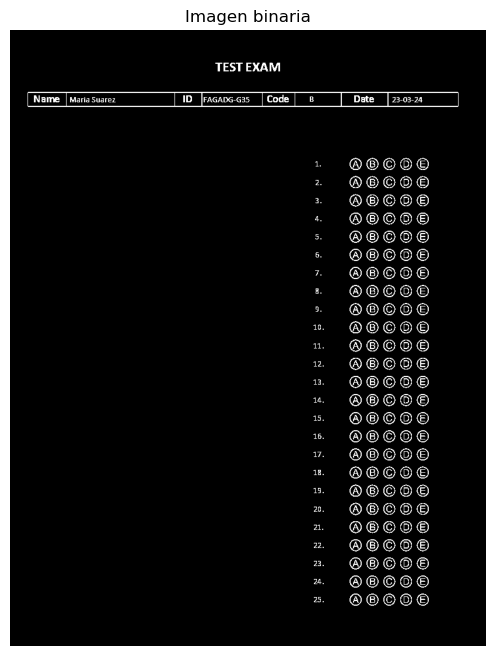

Detectados 125 circulos
Agrupados en 25 preguntas

Respuestas detectadas:
Pregunta 1: Nula
Pregunta 2: Nula
Pregunta 3: Nula
Pregunta 4: Nula
Pregunta 5: Nula
Pregunta 6: Nula
Pregunta 7: Nula
Pregunta 8: Nula
Pregunta 9: Nula
Pregunta 10: Nula
Pregunta 11: Nula
Pregunta 12: Nula
Pregunta 13: Nula
Pregunta 14: Nula
Pregunta 15: Nula
Pregunta 16: Nula
Pregunta 17: Nula
Pregunta 18: Nula
Pregunta 19: Nula
Pregunta 20: Nula
Pregunta 21: Nula
Pregunta 22: Nula
Pregunta 23: Nula
Pregunta 24: Nula
Pregunta 25: Nula


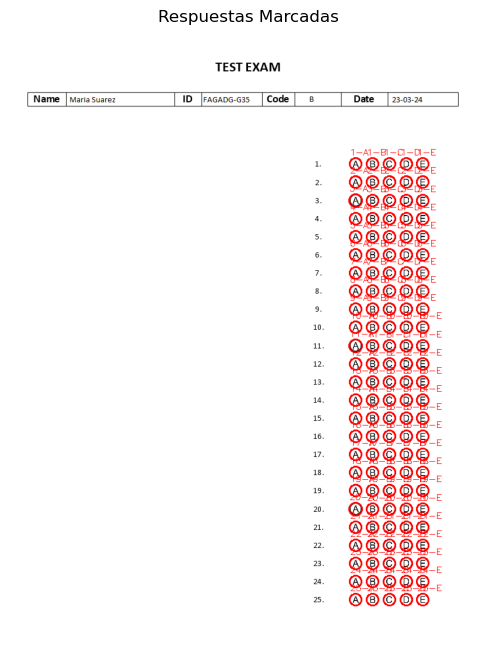


Despuestas detectadas:
Pregunta 1: Nula
Pregunta 2: Nula
Pregunta 3: Nula
Pregunta 4: Nula
Pregunta 5: Nula
Pregunta 6: Nula
Pregunta 7: Nula
Pregunta 8: Nula
Pregunta 9: Nula
Pregunta 10: Nula
Pregunta 11: Nula
Pregunta 12: Nula
Pregunta 13: Nula
Pregunta 14: Nula
Pregunta 15: Nula
Pregunta 16: Nula
Pregunta 17: Nula
Pregunta 18: Nula
Pregunta 19: Nula
Pregunta 20: Nula
Pregunta 21: Nula
Pregunta 22: Nula
Pregunta 23: Nula
Pregunta 24: Nula
Pregunta 25: Nula

Resultados evaluacion:
Respuestas correctas: 0
Respuestas incorrectas: 0
Respuestas nulas: 25
Puntaje: 0 / 100

Resultados detallados:
Pregunta 1: Correcta=A, Marcada=None, Resultado=No contestada
Pregunta 2: Correcta=A, Marcada=None, Resultado=No contestada
Pregunta 3: Correcta=B, Marcada=None, Resultado=No contestada
Pregunta 4: Correcta=A, Marcada=None, Resultado=No contestada
Pregunta 5: Correcta=D, Marcada=None, Resultado=No contestada
Pregunta 6: Correcta=B, Marcada=None, Resultado=No contestada
Pregunta 7: Correcta=B, Mar

In [45]:
datos_ejercicio1 = ejercicio1()

---

# PARTE B

In [46]:
# VISUALIZAR CASILLAS
def visualizar_casillas(imagen_original, rectangulo, casillas):
    """
    Crea la visualización de las casillas de respuesta.
    """
    imagen_con_casillas = imagen_original.copy()
    
    x, y, w, h = rectangulo
    cv2.rectangle(imagen_con_casillas, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    for i, (box_x, box_y, box_w, box_h) in enumerate(casillas):
        cv2.rectangle(imagen_con_casillas, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 0, 255), 2)
        
        cv2.putText(imagen_con_casillas, f"{i+1}", (box_x, box_y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    return imagen_con_casillas

In [47]:
# Función para detectar rectángulos en la imagen binaria
def detectar_rectangulos(imagen_binaria, area_min=1000, area_max=100000, ratio_umbral=0.7):
    """
    Detecta los rectángulos en una imagen binaria.
    """
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangulos = []
    
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        
        if area_min < area < area_max:
            x, y, w, h = cv2.boundingRect(contorno)
            
            # Calcular relación de aspecto
            aspect_ratio = float(w) / h if h > 0 else 0
            
            # Aproximar el contorno a un polígono
            epsilon = 0.04 * cv2.arcLength(contorno, True)
            approx = cv2.approxPolyDP(contorno, epsilon, True)
            
            if len(approx) == 4 or aspect_ratio > ratio_umbral or aspect_ratio < (1/ratio_umbral):
                rectangulos.append((x, y, w, h))
    
    return rectangulos



In [48]:

# Function to visualize detected rectangles
def visualizar_rectangulos(imagen_original, rectangulos):
    """
    Crea una visualización de los rectángulos detectados sobre la imagen original.
    """
    imagen_con_rectangulos = imagen_original.copy()
    
    for i, (x, y, w, h) in enumerate(rectangulos):
        color = (0, 255, 0) 
        if i % 3 == 1:
            color = (255, 0, 0) 
        elif i % 3 == 2:
            color = (0, 0, 255) 
            
        cv2.rectangle(imagen_con_rectangulos, (x, y), (x + w, y + h), color, 2)
        cv2.putText(imagen_con_rectangulos, f"Rect {i+1}", (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_rectangulos

In [49]:
# Función para visualizar cada celda de la tabla por separado
def visualizar_celdas_individuales(imagen_original, celdas):
    """
    Crea visualizaciones individuales para cada celda detectada de la tabla.
    """
    for idx, celda in enumerate(celdas):
        x, y, w, h = celda
        
        # Extraer la celda de la imagen original
        celda_img = imagen_original[y:y+h, x:x+w]
        
        # Crear un borde alrededor de la celda para mejor visibilidad
        celda_con_borde = cv2.copyMakeBorder(
            celda_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        
        titulo = f"Celda {idx+1}"
        
        mostrar_imagen(celda_con_borde, titulo)


In [50]:
# Función para dividir un rectángulo en celdas basadas en barras verticales
def dividir_rectangulo_en_celdas(imagen_binaria, rectangulo, num_celdas_esperadas=8):

    """
    Divide un rectángulo en celdas basadas en barras verticales.
    """
    x, y, w, h = rectangulo
    
    # Extraer la región de interés (ROI)
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    
    # Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h, w), dtype=np.uint8) * 255
    for i in range(w):
        cv2.line(proj_img, (i, h), (i, h - int(v_proj_norm[i])), 0, 1)
    
    mostrar_imagen(proj_img, "Proyección Vertical")
    
    # Detectar picos en la proyección (posibles separadores de celdas)
    # Un pico es un punto donde la proyección es mayor que sus vecinos
    picos = []
    for i in range(1, w-1):
        if v_proj[i] > v_proj[i-1] and v_proj[i] > v_proj[i+1]:
            # Verificar si es un pico significativo (valor alto)
            if v_proj[i] == 255:#> np.mean(v_proj) * 1.5:
                picos.append(i)
    
    # Si no se encontraron suficientes picos, buscar los puntos más altos
    if len(picos) < num_celdas_esperadas - 1:
        # Ordenar todos los puntos por valor de proyección (de mayor a menor)
        todos_puntos = sorted(range(1, w-1), key=lambda i: v_proj[i], reverse=True)
        
        # Tomar los primeros puntos como picos (excluyendo puntos muy cercanos)
        picos = []
        for punto in todos_puntos:
            # Verificar si está lejos de los picos ya encontrados
            if all(abs(punto - p) > w * 0.05 for p in picos):
                picos.append(punto)
                if len(picos) >= num_celdas_esperadas - 1:
                    break
    
    # Ordenar los picos de izquierda a derecha
    picos.sort()
    
    # Dibujar los picos en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for pico in picos:
        cv2.line(proj_img_color, (pico, 0), (pico, h), (0, 0, 255), 1)
    
    mostrar_imagen(proj_img_color, "Separadores Detectados")
    
    # Crear las celdas basadas en los picos
    celdas = []
    
    # Añadir la primera celda (desde el inicio hasta el primer valle)
    if picos:
        celdas.append((x, y, picos[0], h))
    
    # Añadir celdas intermedias
    for i in range(len(picos) - 1):
        celda_x = x + picos[i]
        celda_w = picos[i+1] - picos[i]
        celdas.append((celda_x, y, celda_w, h))
    
    # Añadir la última celda (desde el último valle hasta el final)
    if picos:
        celda_x = x + picos[-1]
        celda_w = w - picos[-1]
        celdas.append((celda_x, y, celda_w, h))
    
    # Si no se encontraron picos, usar todo el rectángulo como una celda
    if not celdas:
        celdas.append((x, y, w, h))
    
    # Dibujar las celdas en la visualización del ROI
    for i, (cx, cy, cw, ch) in enumerate(celdas):
        # Ajustar coordenadas para ser relativas al ROI
        local_x, local_y = cx - x, cy - y
        cv2.rectangle(roi_visual, (local_x, local_y), (local_x + cw, local_y + ch), (0, 255, 0), 1)
        cv2.putText(roi_visual, str(i+1), (local_x + 5, local_y + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    mostrar_imagen(roi_visual, "Celdas Divididas")
    
    return celdas


In [51]:
def analyze_character_connectivity(region):
    """
    Analiza la conectividad de los píxeles blancos en una región para determinar
    si contiene uno o más caracteres.
    """
    # Crear una copia para visualización
    region_visual = cv2.cvtColor(region.copy(), cv2.COLOR_GRAY2BGR)
    h, w = region.shape
    
    # Aplicar análisis de componentes conectadas a los píxeles blancos (255)
    # El segundo parámetro 8 indica conectividad de 8 vecinos
    num_labels, labels = cv2.connectedComponents(region, connectivity=8)
    
    # Si hay más de una componente conectada (excluyendo el fondo), 
    # podría haber múltiples caracteres
    divisiones = []
    
    if num_labels > 2:  # Más de un componente (excluyendo el fondo)
        # Crear una imagen para visualizar las componentes
        label_hue = np.uint8(179 * labels / np.max(labels))
        blank_ch = 255 * np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
        labeled_img[label_hue == 0] = 0  # Fondo negro
        
        # Encontrar los límites de cada componente
        componentes = {}
        for i in range(1, num_labels):  # Excluir el fondo (0)
            componentes[i] = np.where(labels == i)
            
        # Ordenar componentes por posición x
        comp_ordenadas = sorted(componentes.items(), 
                               key=lambda x: np.min(x[1][1]) if len(x[1][1]) > 0 else 0)
        
        # Encontrar divisiones entre componentes
        for i in range(len(comp_ordenadas) - 1):
            comp_actual = comp_ordenadas[i]
            comp_siguiente = comp_ordenadas[i + 1]
            
            # Encontrar el límite derecho de la componente actual
            x_max_actual = np.max(comp_actual[1][1]) if len(comp_actual[1][1]) > 0 else 0
            
            # Encontrar el límite izquierdo de la siguiente componente
            x_min_siguiente = np.min(comp_siguiente[1][1]) if len(comp_siguiente[1][1]) > 0 else w
            
            # Calcular el punto medio entre componentes
            division = (x_max_actual + x_min_siguiente) // 2
            
            # Verificar que la división sea válida
            if 0 < division < w - 1:
                divisiones.append(division)
                # Dibujar línea de división en la visualización
                cv2.line(region_visual, (division, 0), (division, h), (0, 0, 255), 1)
    
    return divisiones, region_visual


In [52]:

def extract_and_count_text(roi_binaria, margen_borde=5):
    """
    Extrae y cuenta caracteres y palabras en una imagen de texto.
    """
    # 1. Recortar los bordes para eliminar líneas de la tabla
    h, w = roi_binaria.shape
    if h > 2*margen_borde and w > 2*margen_borde:
        roi_recortada = roi_binaria[margen_borde:h-margen_borde, margen_borde:w-margen_borde]
    else:
        roi_recortada = roi_binaria.copy()
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_recortada.copy(), cv2.COLOR_GRAY2BGR)
    h_rec, w_rec = roi_recortada.shape
    
    # 2. Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi_recortada, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h_rec if np.max(v_proj) > 0 else np.zeros_like(v_proj)
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h_rec, w_rec), dtype=np.uint8) * 255
    for i in range(w_rec):
        if np.max(v_proj) > 0:  # Evitar división por cero
            cv2.line(proj_img, (i, h_rec), (i, h_rec - int(v_proj_norm[i])), 0, 1)
    
    # Crear una versión a color de la imagen de proyección para visualización
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    
    # 3. Detectar valles en la proyección (espacios entre caracteres)
    # Calcular el umbral dinámico basado en la proyección
    umbral_valle = np.mean(v_proj) * 0.3  # Ajustar este valor según sea necesario
    
    # Encontrar los valles (puntos donde la proyección es menor que el umbral)
    valles = []
    for i in range(1, w_rec-1):
        # Un valle es donde la proyección es baja y está rodeada por valores más altos
        if v_proj[i] < umbral_valle and v_proj[i] <= v_proj[i-1] and v_proj[i] <= v_proj[i+1]:
            valles.append(i)
    
    # Mejorar la detección de valles buscando secuencias completas de valores bajos
    # Esto ayuda a detectar espacios más amplios entre caracteres y palabras
    secuencias_valles = []  # Lista para almacenar las secuencias de valles (inicio, fin, longitud)
    secuencia_actual = []
    
    for i in range(w_rec):
        if v_proj[i] < umbral_valle:
            secuencia_actual.append(i)
        elif secuencia_actual:
            # Si terminó una secuencia, procesarla
            if len(secuencia_actual) > 0:
                inicio = secuencia_actual[0]
                fin = secuencia_actual[-1]
                longitud = fin - inicio + 1
                secuencias_valles.append((inicio, fin, longitud))
                
                # Añadir el punto medio de la secuencia como valle
                punto_medio = (inicio + fin) // 2
                if punto_medio not in valles:
                    valles.append(punto_medio)
            secuencia_actual = []
    
    # No olvidar la última secuencia si existe
    if secuencia_actual:
        inicio = secuencia_actual[0]
        fin = secuencia_actual[-1]
        longitud = fin - inicio + 1
        secuencias_valles.append((inicio, fin, longitud))
        
        punto_medio = (inicio + fin) // 2
        if punto_medio not in valles:
            valles.append(punto_medio)
    
    # Ordenar los valles
    valles.sort()
    
    # 4. Identificar espacios significativos (para contar palabras)
    # Analizar las longitudes de las secuencias de valles para identificar espacios entre palabras
    longitudes_secuencias = [longitud for _, _, longitud in secuencias_valles]
    
    if longitudes_secuencias:
        # Calcular estadísticas de las longitudes
        longitud_media = np.mean(longitudes_secuencias)
        longitud_std = np.std(longitudes_secuencias) if len(longitudes_secuencias) > 1 else longitud_media * 0.5
        
        # Umbral adaptativo para identificar espacios entre palabras
        # Un espacio entre palabras debería ser significativamente más largo que entre caracteres
        umbral_espacio_palabra = longitud_media + 1.5 * longitud_std
        
        # Identificar valles que corresponden a espacios entre palabras
        valles_palabras = []
        for inicio, fin, longitud in secuencias_valles:
            if longitud > umbral_espacio_palabra:
                punto_medio = (inicio + fin) // 2
                valles_palabras.append(punto_medio)
                
                # Visualizar estos valles especiales en la proyección
                cv2.line(proj_img_color, (punto_medio, 0), (punto_medio, h_rec), (0, 165, 255), 2)
    else:
        valles_palabras = []
    
    # Calcular distancias entre valles consecutivos (método original como respaldo)
    distancias_valles = []
    for i in range(1, len(valles)):
        distancias_valles.append(valles[i] - valles[i-1])
    
    # Si hay distancias, calcular un umbral para espacios entre palabras
    if distancias_valles:
        dist_media = np.mean(distancias_valles)
        dist_std = np.std(distancias_valles) if len(distancias_valles) > 1 else dist_media * 0.5
        umbral_espacio = dist_media + 1.5 * dist_std  # Umbral adaptativo
    else:
        umbral_espacio = w_rec // 4  # Valor predeterminado si no hay suficientes valles
    
    # 5. Añadir el inicio y el final como límites
    limites = [0] + valles + [w_rec-1]
    limites.sort()
    
    # 6. Filtrar límites muy cercanos (pueden ser ruido)
    limites_filtrados = [limites[0]]
    for i in range(1, len(limites)):
        if limites[i] - limites_filtrados[-1] > 3:  # Mínima distancia entre límites
            limites_filtrados.append(limites[i])
    
    # 7. Dibujar los límites en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for limite in limites_filtrados:
        cv2.line(proj_img_color, (limite, 0), (limite, h_rec), (0, 0, 255), 1)
    
    # 8. Extraer caracteres basados en los límites
    caracteres = []
    coords = []
    espacios_palabras = []
    
    # 8.1 Primero, extraer todos los segmentos potenciales
    segmentos = []
    for i in range(len(limites_filtrados) - 1):
        start = limites_filtrados[i]
        end = limites_filtrados[i + 1]
        
        # Verificar si hay suficiente contenido entre los límites
        region = roi_recortada[:, start:end]
        if np.sum(region) > 0 and end - start > 2:  # Evitar regiones vacías o muy pequeñas
            segmentos.append((start, end, region.copy()))
    
    # 8.2 Analizar los segmentos para detectar caracteres múltiples
    if segmentos:
        # Calcular el ancho de cada segmento
        anchos = [end - start for start, end, _ in segmentos]
        
        # Encontrar el ancho mínimo (probablemente un solo carácter)
        ancho_min = min(anchos)
        
        # Umbral para considerar un segmento como múltiple (ajustar según sea necesario)
        umbral_multiple = ancho_min * 1.5  # Si es 1.8 veces más ancho que el mínimo
        
        for idx, (start, end, region) in enumerate(segmentos):
            ancho = end - start
            
            # Verificar si este segmento podría contener múltiples caracteres
            if ancho > umbral_multiple:
                # Analizar la conectividad de los píxeles blancos en la región
                divisiones, region_conectividad = analyze_character_connectivity(region)
                
                if divisiones:
                    # Convertir divisiones locales a globales
                    divisiones_globales = [d + start for d in divisiones]
                    
                    # Dibujar divisiones en la visualización principal
                    for division in divisiones_globales:
                        cv2.line(roi_visual, (division, 0), (division, h_rec), (255, 0, 0), 1)
                    
                    # Añadir el inicio y el final del segmento
                    sub_limites = [start] + divisiones_globales + [end]
                    sub_limites.sort()
                    
                    # Extraer cada sub-segmento como un carácter
                    for j in range(len(sub_limites) - 1):
                        sub_start = sub_limites[j]
                        sub_end = sub_limites[j + 1]
                        
                        # Verificar si hay suficiente contenido
                        sub_region = roi_recortada[:, sub_start:sub_end]
                        if np.sum(sub_region) > 0 and sub_end - sub_start > 2:
                            # Guardar el carácter
                            caracteres.append(sub_region.copy())
                            coords.append((sub_start, 0, sub_end - sub_start, h_rec))
                            
                            # Dibujar rectángulo en la visualización
                            cv2.rectangle(roi_visual, (sub_start, 0), (sub_end, h_rec), (0, 255, 0), 1)
                            cv2.putText(roi_visual, str(len(caracteres)), (sub_start, 15), 
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                else:
                    # No se encontraron divisiones por conectividad, tratar como un solo carácter
                    caracteres.append(region)
                    coords.append((start, 0, ancho, h_rec))
                    
                    # Dibujar rectángulo en la visualización
                    cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                    cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            else:
                # Segmento normal, tratar como un solo carácter
                caracteres.append(region)
                coords.append((start, 0, ancho, h_rec))
                
                # Dibujar rectángulo en la visualización
                cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    # 9. Identificar espacios entre palabras basados en las coordenadas finales
    if len(coords) > 1:
        # Ordenar coordenadas por posición x
        coords_ordenadas = sorted(coords, key=lambda c: c[0])
        
        # Calcular distancias entre caracteres consecutivos
        distancias = []
        for i in range(len(coords_ordenadas) - 1):
            distancia = coords_ordenadas[i+1][0] - (coords_ordenadas[i][0] + coords_ordenadas[i][2])
            distancias.append(distancia)
        
        # Calcular distancia promedio y umbral para considerar un espacio
        if distancias:
            dist_promedio = sum(distancias) / len(distancias)
            umbral_espacio = dist_promedio * 1.5
            
            # Identificar espacios significativos
            for i, dist in enumerate(distancias):
                if dist > umbral_espacio:
                    espacios_palabras.append(i)
                    
                    # Marcar espacio entre palabras en la visualización
                    x1 = coords_ordenadas[i][0] + coords_ordenadas[i][2]
                    x2 = coords_ordenadas[i+1][0]
                    mid = (x1 + x2) // 2
                    cv2.line(roi_visual, (mid, 0), (mid, h_rec), (0, 165, 255), 2)
    
    # 10. Contar caracteres y palabras
    num_caracteres = len(caracteres)
    num_palabras = len(espacios_palabras) + 1 if num_caracteres > 0 else 0
    
    # Añadir información de conteo a la imagen
    cv2.putText(roi_visual, f"Chars: {num_caracteres}, Words: {num_palabras}", 
               (5, h_rec - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img_color

In [53]:
def ejercicio2(ruta_imagen):
    """
    Función principal que procesa una imagen para:
    1. Obtener la imagen binaria
    2. Encontrar los rectángulos en la imagen
    3. Dividir el rectángulo en celdas basadas en barras verticales
    4. Separar y contar caracteres y palabras en cada celda
    """
    # Verificar si la imagen existe
    if not os.path.exists(ruta_imagen):
        print(f"Error: Imagen no encontrada en {ruta_imagen}")
        return None
    
    # Leer la imagen
    imagen = cv2.imread(ruta_imagen)
    
    if imagen is None:
        print(f"Error: No se pudo leer la imagen en {ruta_imagen}")
        return None
    
    # Mostrar imagen original
    mostrar_imagen(imagen, "Imagen Original")
    
    # 1. Obtener imagen binaria
    print("1. Obteniendo imagen binaria...")
    binaria = obtener_imagen_binaria(imagen, umbral=130)
    mostrar_imagen(binaria, "Imagen Binaria")
    
    # 2. Detectar rectángulos en la imagen binaria
    print("2. Detectando rectángulos...")
    rectangulos = detectar_rectangulos(binaria)
    print(f"   Se detectaron {len(rectangulos)} rectángulos")
    
    # Verificar si se encontró al menos un rectángulo
    if not rectangulos:
        print("Error: No se detectaron rectángulos en la imagen")
        return None
    
    # Visualizar rectángulos detectados
    imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
    mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
    
    # Tomar el primer rectángulo (debería ser el único según el requerimiento)
    rectangulo_principal = rectangulos[0]
    
    # 3. Dividir el rectángulo en celdas basadas en barras verticales
    print("3. Dividiendo el rectángulo en celdas...")
    celdas = dividir_rectangulo_en_celdas(binaria, rectangulo_principal)
    print(f"   Se dividió el rectángulo en {len(celdas)} celdas")
        
    # Visualizar las celdas
    imagen_con_celdas = visualizar_casillas(imagen, rectangulo_principal, celdas)
    mostrar_imagen(imagen_con_celdas, "Todas las Celdas Detectadas")
    
    # Mostrar cada celda individualmente
    print("Mostrando celdas individuales:")
    for idx, celda in enumerate(celdas):
        x, y, w, h = celda
        # Extraer la región de la celda de la imagen original
        celda_img = imagen[y:y+h, x:x+w].copy()
        # Dibujar un borde para mejor visualización
        cv2.rectangle(celda_img, (0, 0), (w-1, h-1), (0, 255, 0), 2)
        # Mostrar la celda individual
        mostrar_imagen(celda_img, f"Celda {idx+1} de {len(celdas)}")


    # 4. Separar y contar caracteres y palabras en cada celda
    print("4. Analizando caracteres y palabras en cada celda...")
    resultados_celdas = {}
    
    for idx_celda, celda in enumerate(celdas):
        print(f"\n   Procesando Celda {idx_celda+1}:")
        
        # Extraer la región de interés (ROI) de la celda
        x, y, w, h = celda
        roi_binaria = binaria[y:y+h, x:x+w]
        
        # Extraer caracteres usando proyección vertical y capturar los resultados
        caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img = extract_and_count_text(roi_binaria)
        
        # Mostrar la proyección vertical con límites
        mostrar_imagen(proj_img, f"Proyección y Límites - Celda {idx_celda+1}")
        
        # Mostrar la celda con los caracteres detectados
        mostrar_imagen(roi_visual, f"Caracteres en Celda {idx_celda+1}")
        
        # Contar caracteres
        num_caracteres = len(caracteres)
        
        # Contar palabras usando espacios significativos entre caracteres
        num_palabras = 1 if num_caracteres > 0 else 0
        if len(coords) > 1:
            # Calcular distancia promedio entre caracteres
            distancias = []
            for i in range(len(coords) - 1):
                distancia = coords[i+1][0] - (coords[i][0] + coords[i][2])
                distancias.append(distancia)
            
            # Calcular distancia promedio y umbral para considerar un espacio
            if distancias:
                dist_promedio = sum(distancias) / len(distancias)
                umbral_espacio = dist_promedio * 1.5
                
                # Contar palabras basadas en espacios significativos
                for dist in distancias:
                    if dist > umbral_espacio:
                        num_palabras += 1
        
        # Guardar resultados
        resultados_celdas[idx_celda] = {
            'caracteres': caracteres,
            'coords': coords,
            'num_caracteres': num_caracteres,
            'num_palabras': num_palabras
        }
        
        # Mostrar resultados
        print(f"   Celda {idx_celda+1}: {num_caracteres} caracteres, {num_palabras} palabras")
        
        # Mostrar caracteres individuales si hay alguno
        if caracteres and len(caracteres) > 0:
            # Limitar el número de caracteres a mostrar
            max_chars_to_show = min(len(caracteres), 25)
            
            if max_chars_to_show > 0:
                fig, axes = plt.subplots(1, max_chars_to_show, figsize=(max_chars_to_show*1.5, 2))
                fig.suptitle(f"Caracteres en Celda {idx_celda+1}")
                
                # Asegurar que axes sea iterable incluso con un solo carácter
                if max_chars_to_show == 1:
                    axes = [axes]
                
                for i in range(max_chars_to_show):
                    axes[i].imshow(caracteres[i], cmap='gray')
                    axes[i].set_title(f"Char {i+1}")
                    axes[i].axis('off')
                
                plt.tight_layout()
                plt.show()
    
        # Crear una imagen resumen con los conteos
    imagen_resultados = imagen.copy()
    for idx_celda, data in resultados_celdas.items():
        if idx_celda < len(celdas):
            x, y, w, h = celdas[idx_celda]
            num_chars = data['num_caracteres']
            num_words = data['num_palabras']
            
            # Validar la celda según los requisitos específicos
            es_valida = False
            mensaje_validacion = ""
            
            # Criterios de validación según el índice de la celda
            if idx_celda == 1:  # Celda 2 (índice 1): 2 palabras y no más de 25 caracteres
                es_valida = (num_words == 2) and (num_chars <= 25)
                if not es_valida:
                    if num_words != 2:
                        mensaje_validacion = f"Debe tener 2 palabras (tiene {num_words})"
                    else:
                        mensaje_validacion = f"Debe tener ≤25 caracteres (tiene {num_chars})"
            
            elif idx_celda == 3:  # Celda 4 (índice 3): 1 palabra y 8 caracteres exactos
                es_valida = (num_words == 1) and (num_chars == 8)
                if not es_valida:
                    if num_words != 1:
                        mensaje_validacion = f"Debe tener 1 palabra (tiene {num_words})"
                    else:
                        mensaje_validacion = f"Debe tener 8 caracteres (tiene {num_chars})"
            
            elif idx_celda == 5:  # Celda 6 (índice 5): 1 palabra y 1 carácter exacto
                es_valida = (num_words == 1) and (num_chars == 1)
                if not es_valida:
                    if num_words != 1:
                        mensaje_validacion = f"Debe tener 1 palabra (tiene {num_words})"
                    else:
                        mensaje_validacion = f"Debe tener 1 carácter (tiene {num_chars})"
            
            elif idx_celda == 7:  # Celda 8 (índice 7): 1 palabra y 8 caracteres exactos
                es_valida = (num_words == 1) and (num_chars == 8)
                if not es_valida:
                    if num_words != 1:
                        mensaje_validacion = f"Debe tener 1 palabra (tiene {num_words})"
                    else:
                        mensaje_validacion = f"Debe tener 8 caracteres (tiene {num_chars})"
            else:
                es_valida = True
                mensaje_validacion = "Celda fuera de los criterios especificados"
            
            # Dibujar rectángulo (verde si es válida, rojo si no lo es)
            color = (0, 255, 0) if es_valida else (0, 0, 255)
            cv2.rectangle(imagen_resultados, (x, y), (x + w, y + h), color, 2)
            
            # Añadir etiqueta con conteos
            label = f"C{idx_celda+1}: {num_chars}c, {num_words}w"
            cv2.putText(imagen_resultados, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            
            # Añadir mensaje de validación si la celda no es válida
            if not es_valida and mensaje_validacion:
                cv2.putText(imagen_resultados, mensaje_validacion, (x, y+h+15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            
            # Guardar el resultado de validación en el diccionario
            resultados_celdas[idx_celda]['es_valida'] = es_valida
            if not es_valida:
                resultados_celdas[idx_celda]['mensaje_validacion'] = mensaje_validacion
    
    mostrar_imagen(imagen_resultados, "Resumen de Análisis")

    # Mostrar resumen de validación
    print("\nResumen de validación:")
    for idx_celda, data in resultados_celdas.items():
        if 'es_valida' in data:
            estado = "✓ VÁLIDA" if data['es_valida'] else "✗ INVÁLIDA"
            mensaje = f" - {data.get('mensaje_validacion', '')}" if not data['es_valida'] else ""
            print(f"Celda {idx_celda+1}: {estado}{mensaje}")

    print("\nProcesamiento completado con éxito.")
    
    return {
        'rectangulo': rectangulo_principal,
        'celdas': celdas,
        'resultados_celdas': resultados_celdas
    }


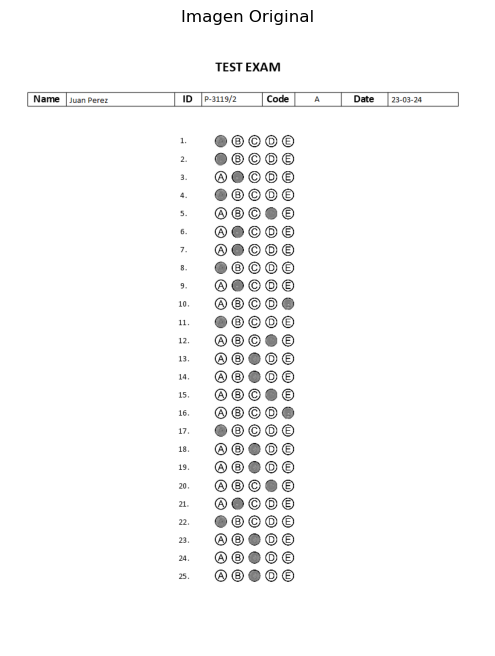

1. Obteniendo imagen binaria...


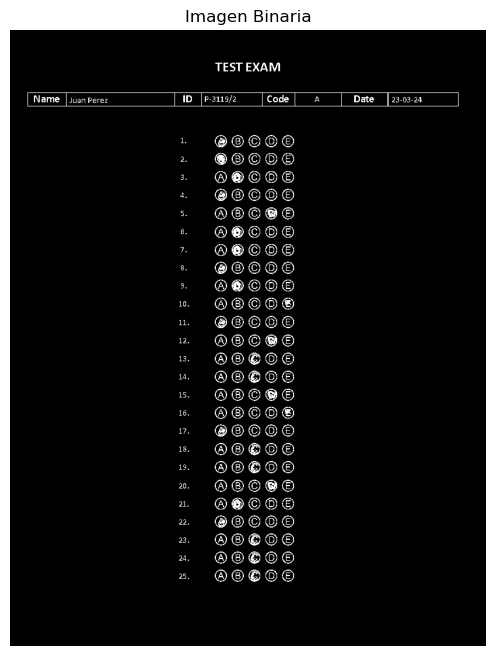

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


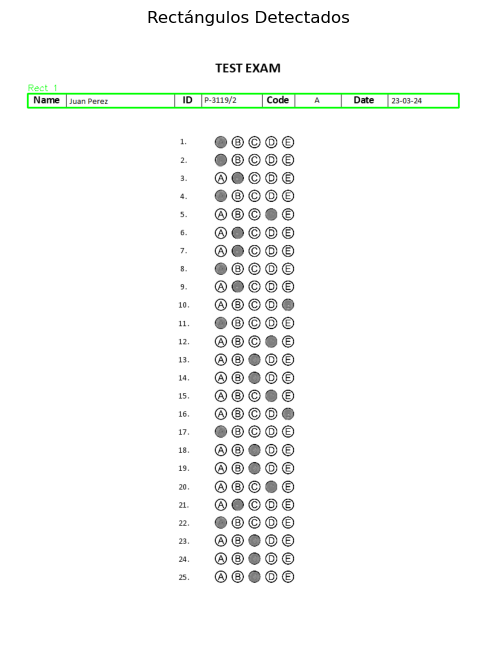

3. Dividiendo el rectángulo en celdas...


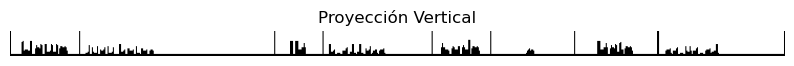

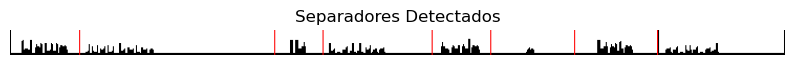

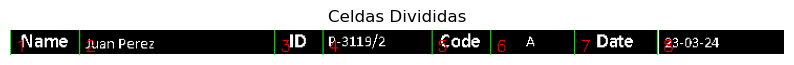

   Se dividió el rectángulo en 8 celdas


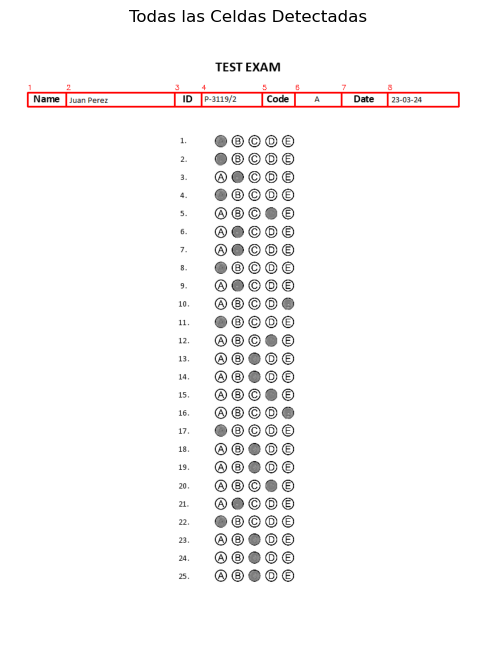

Mostrando celdas individuales:


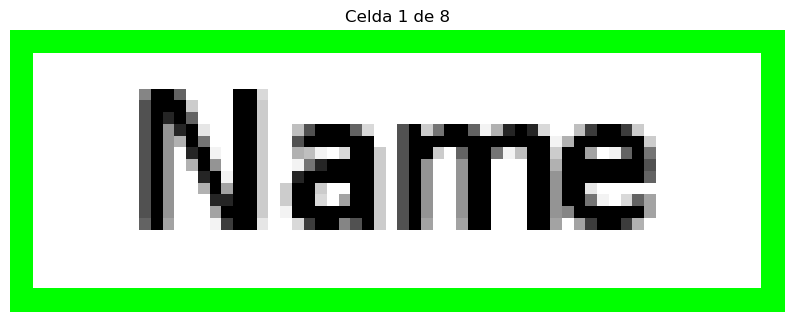

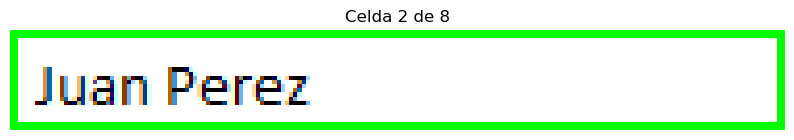

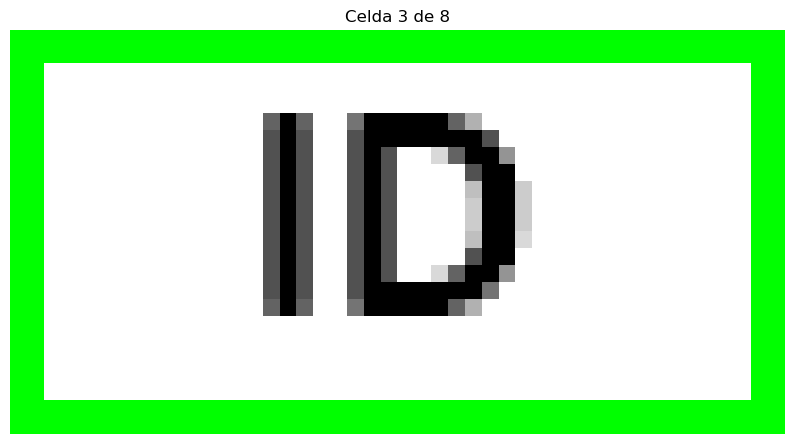

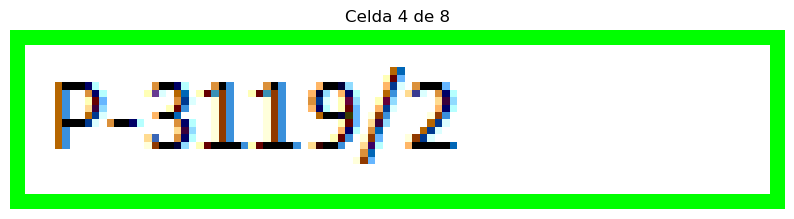

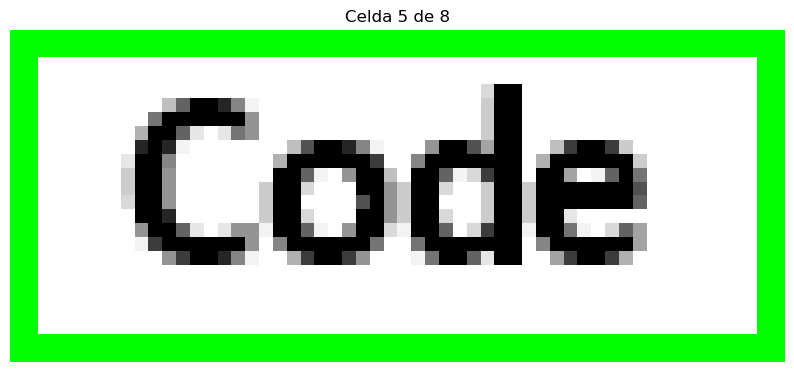

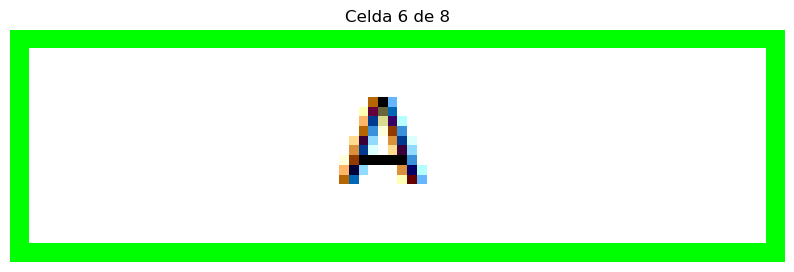

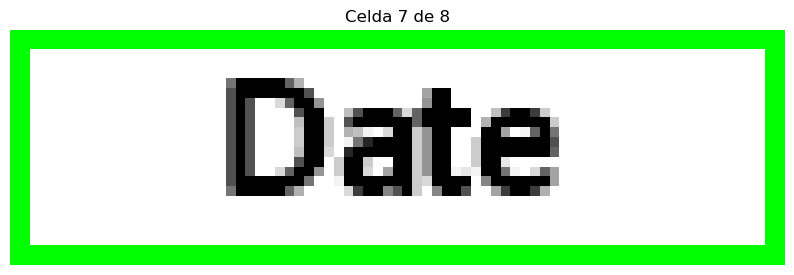

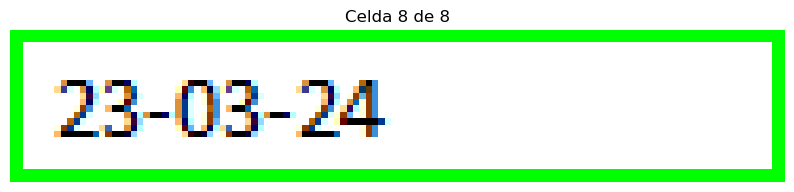

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


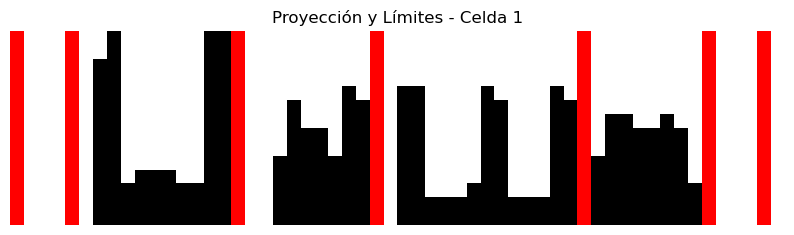

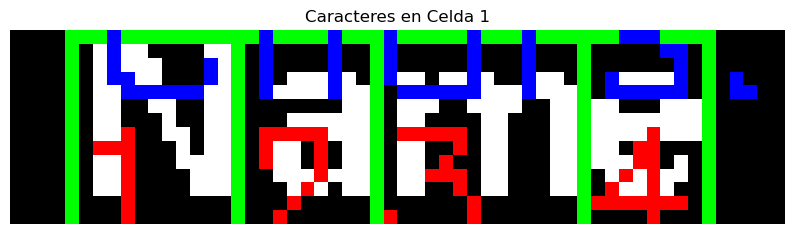

   Celda 1: 4 caracteres, 1 palabras


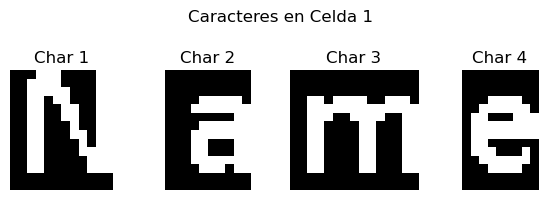


   Procesando Celda 2:


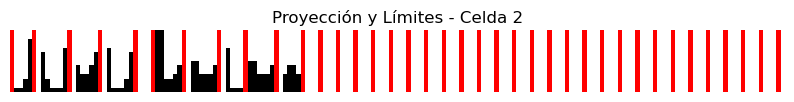

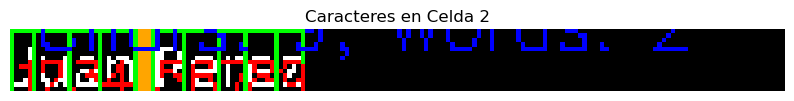

   Celda 2: 9 caracteres, 2 palabras


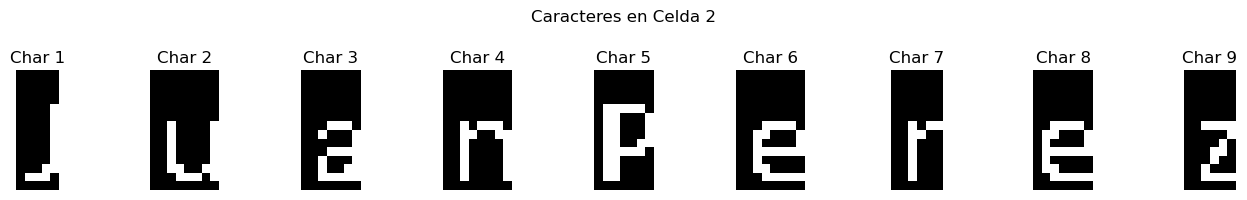


   Procesando Celda 3:


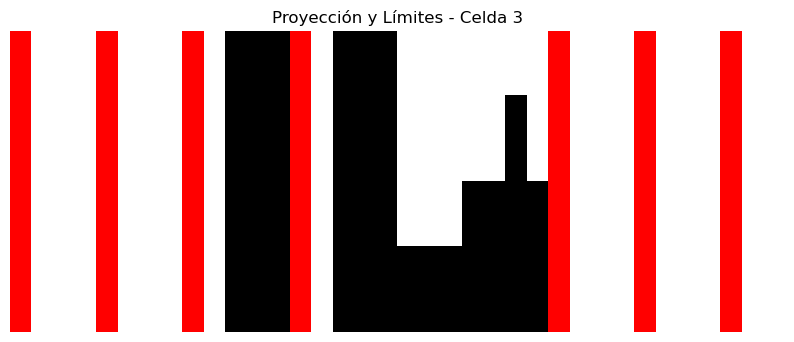

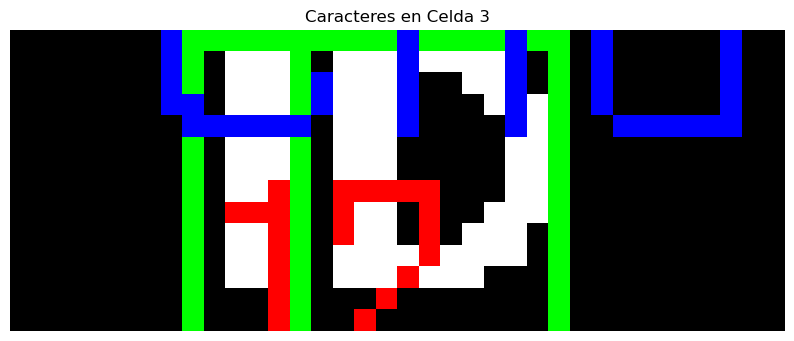

   Celda 3: 2 caracteres, 1 palabras


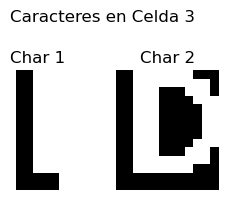


   Procesando Celda 4:


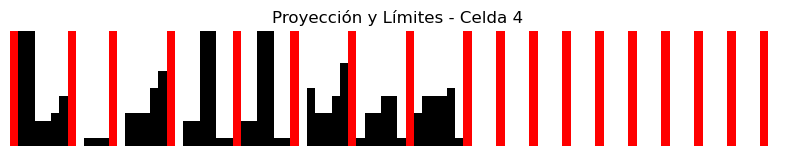

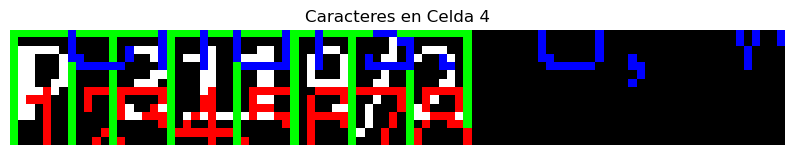

   Celda 4: 8 caracteres, 1 palabras


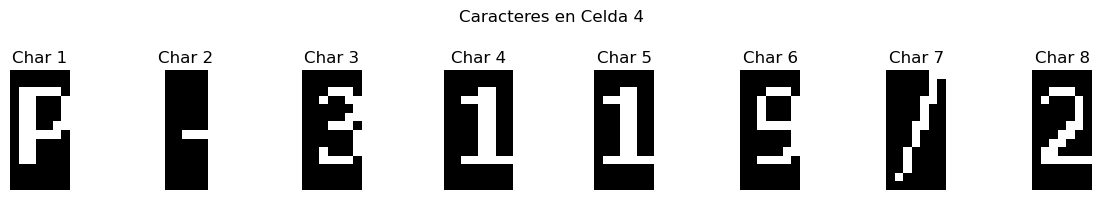


   Procesando Celda 5:


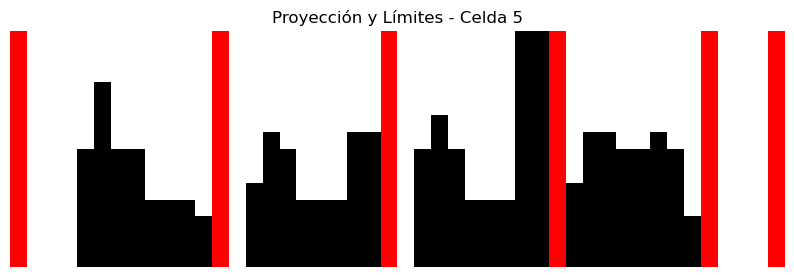

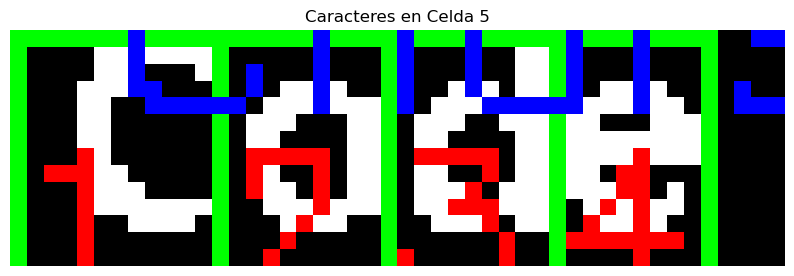

   Celda 5: 4 caracteres, 1 palabras


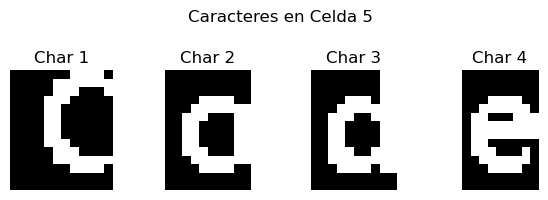


   Procesando Celda 6:


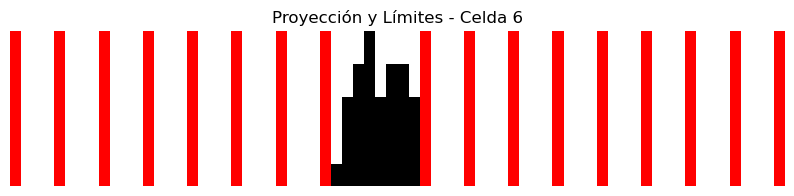

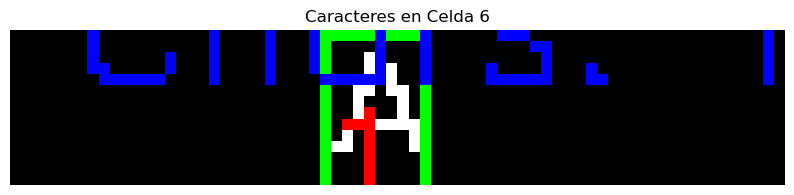

   Celda 6: 1 caracteres, 1 palabras


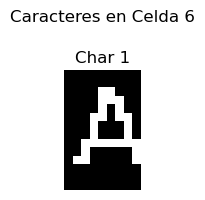


   Procesando Celda 7:


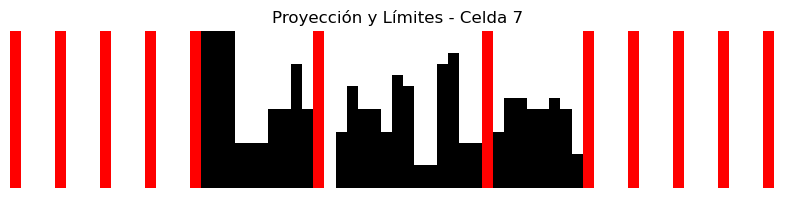

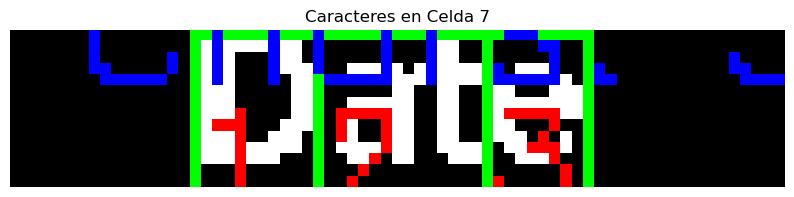

   Celda 7: 3 caracteres, 1 palabras


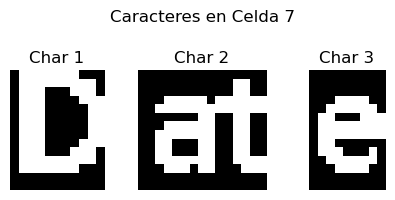


   Procesando Celda 8:


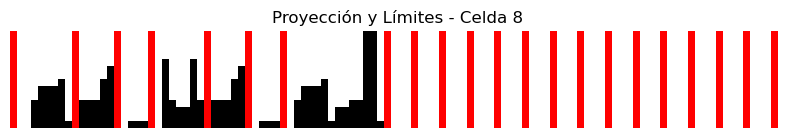

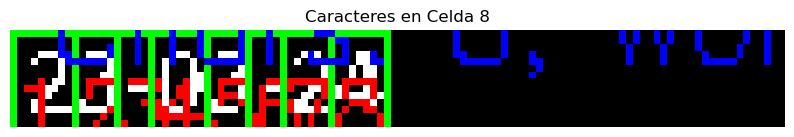

   Celda 8: 8 caracteres, 1 palabras


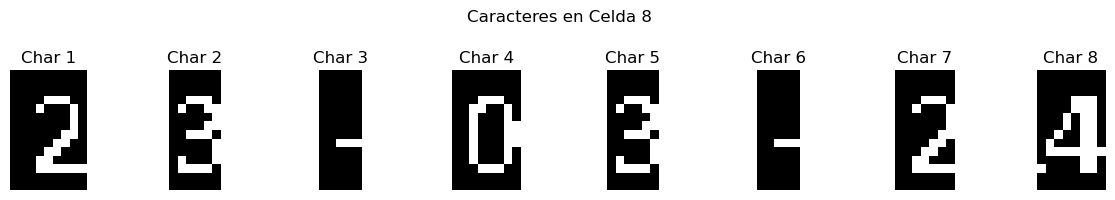

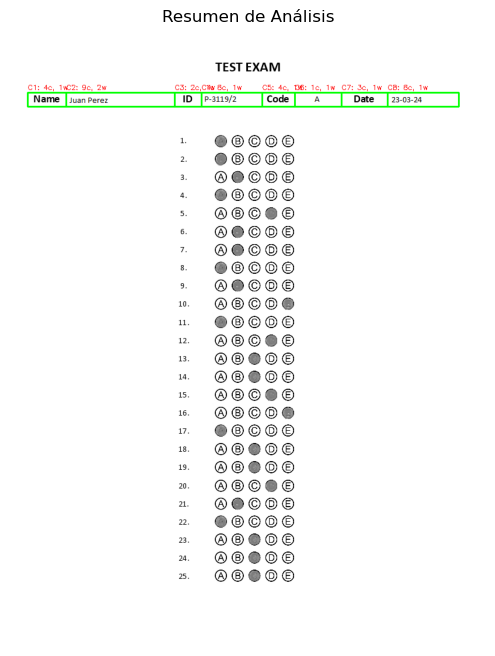


Resumen de validación:
Celda 1: ✓ VÁLIDA
Celda 2: ✓ VÁLIDA
Celda 3: ✓ VÁLIDA
Celda 4: ✓ VÁLIDA
Celda 5: ✓ VÁLIDA
Celda 6: ✓ VÁLIDA
Celda 7: ✓ VÁLIDA
Celda 8: ✓ VÁLIDA

Procesamiento completado con éxito.


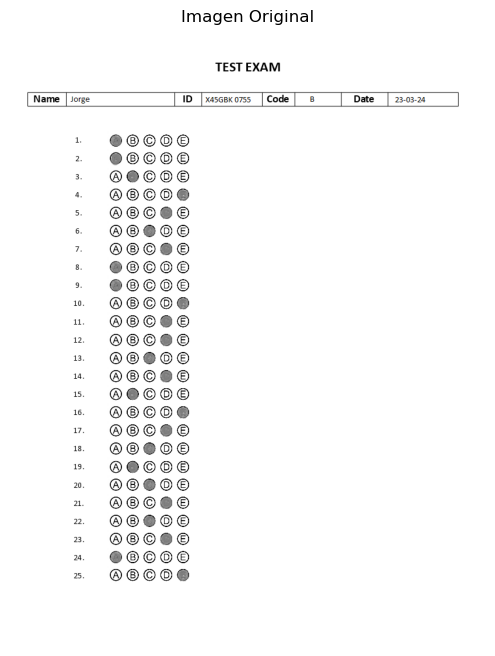

1. Obteniendo imagen binaria...


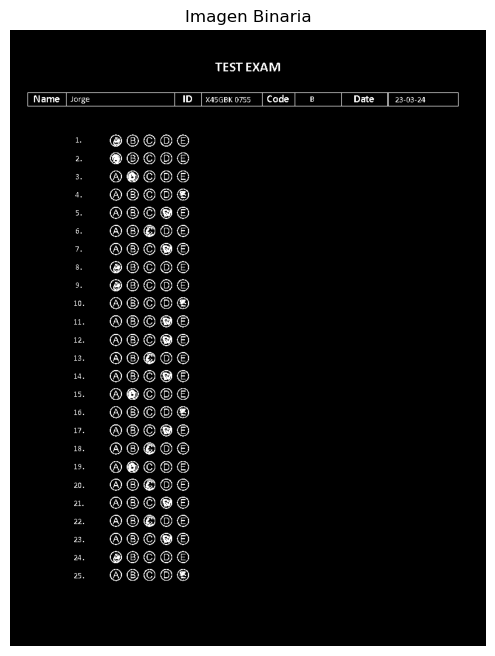

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


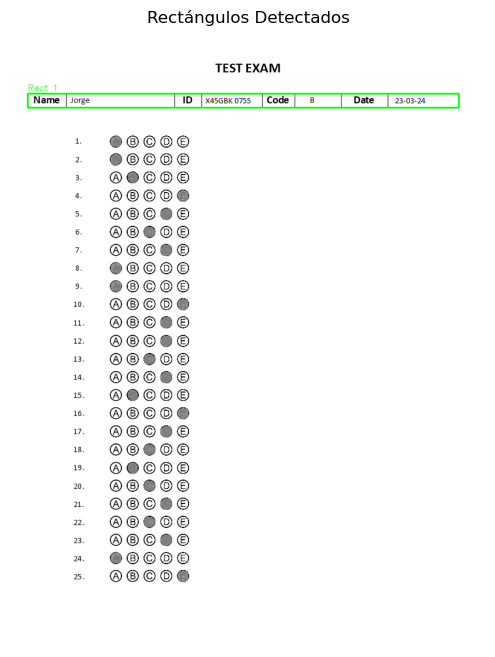

3. Dividiendo el rectángulo en celdas...


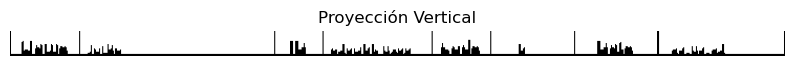

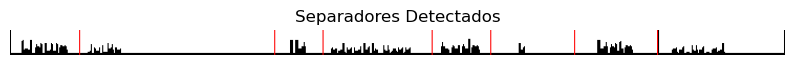

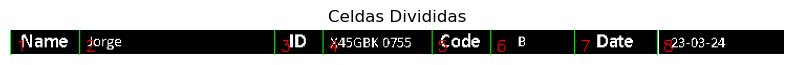

   Se dividió el rectángulo en 8 celdas


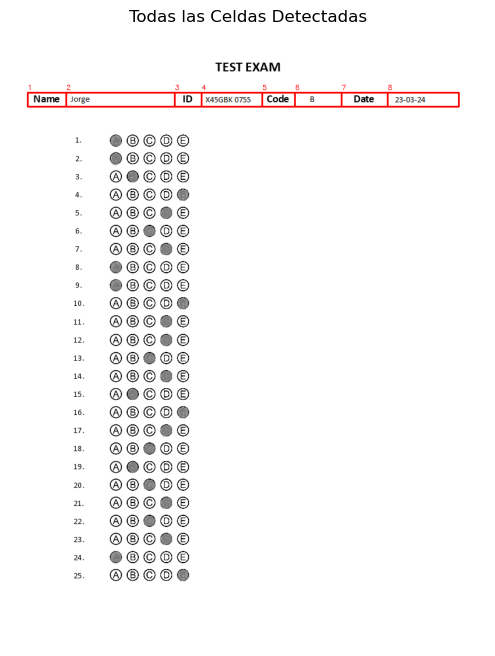

Mostrando celdas individuales:


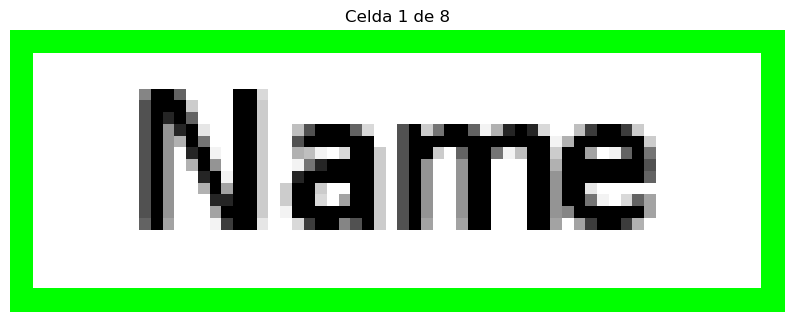

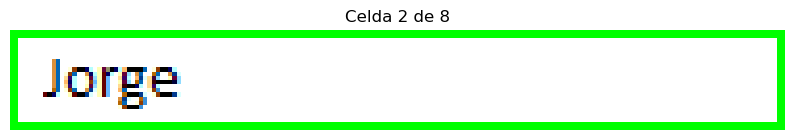

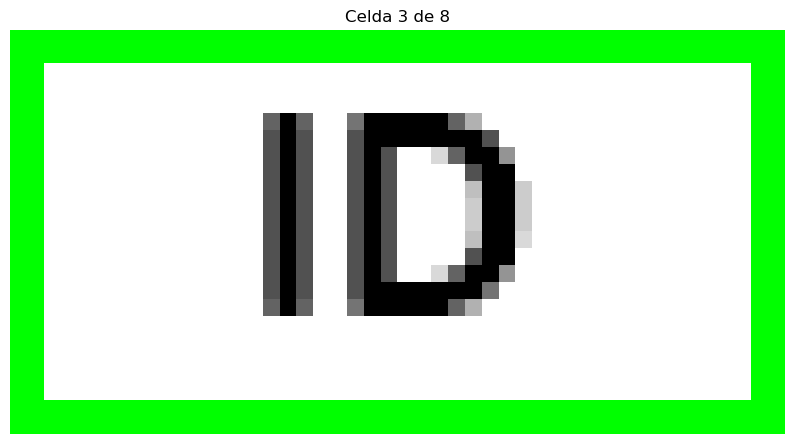

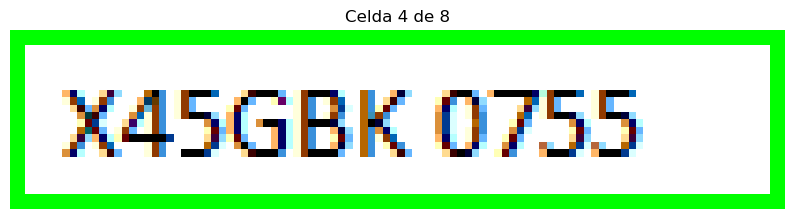

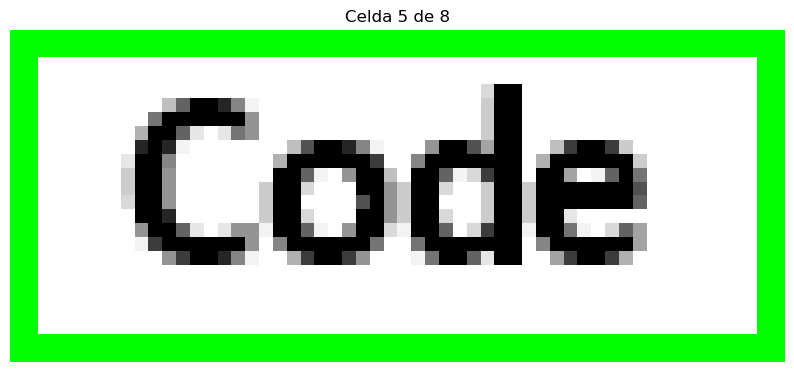

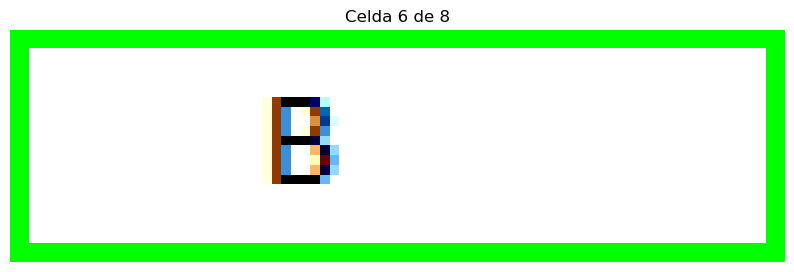

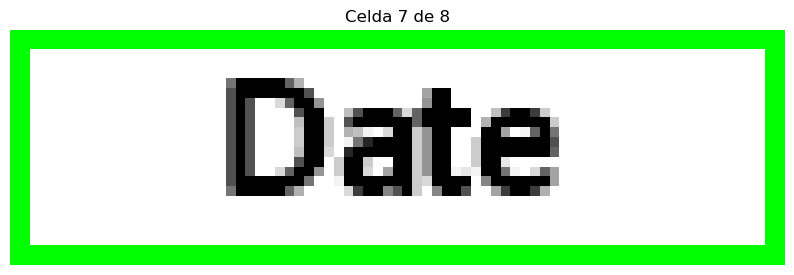

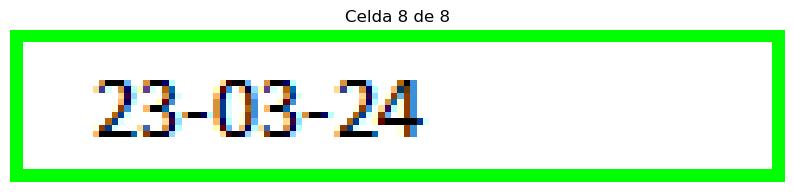

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


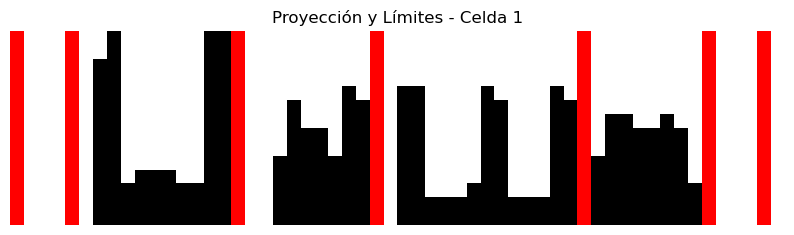

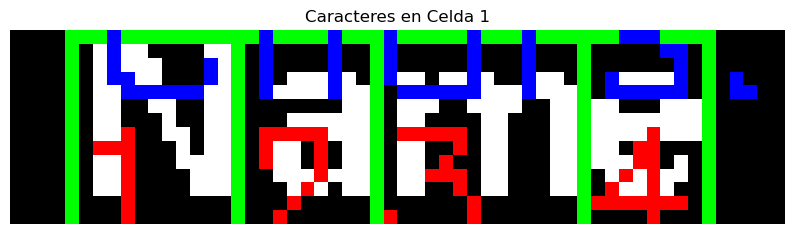

   Celda 1: 4 caracteres, 1 palabras


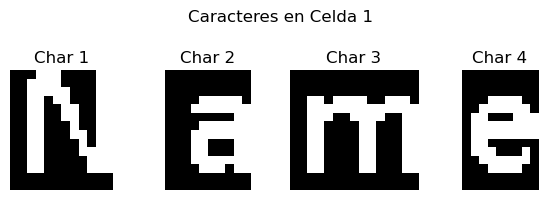


   Procesando Celda 2:


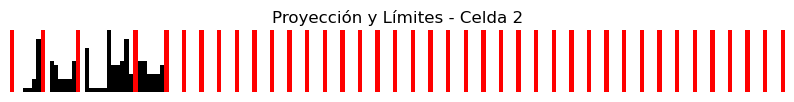

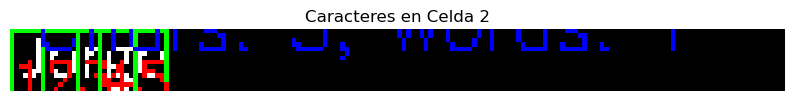

   Celda 2: 5 caracteres, 1 palabras


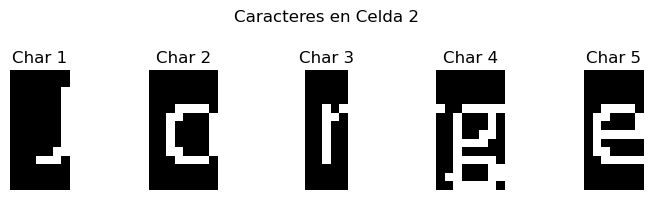


   Procesando Celda 3:


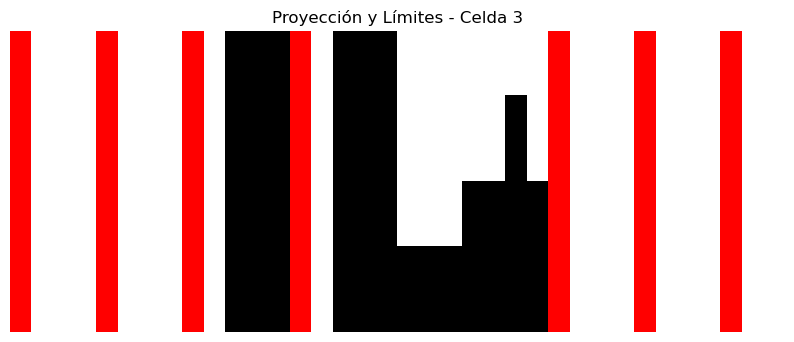

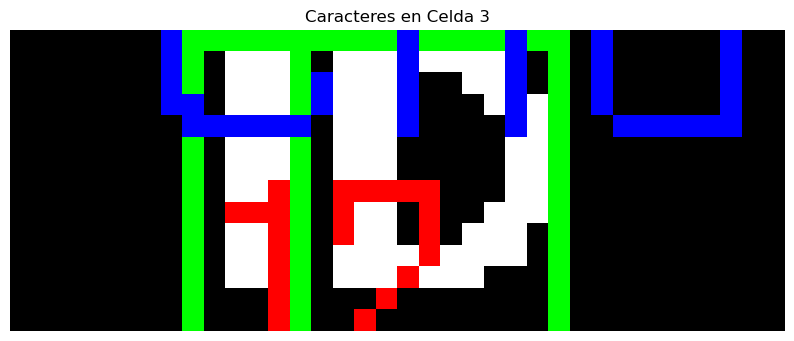

   Celda 3: 2 caracteres, 1 palabras


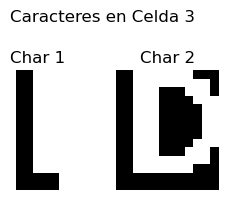


   Procesando Celda 4:


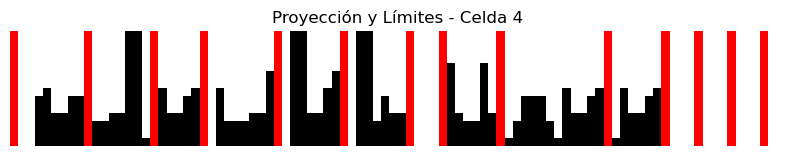

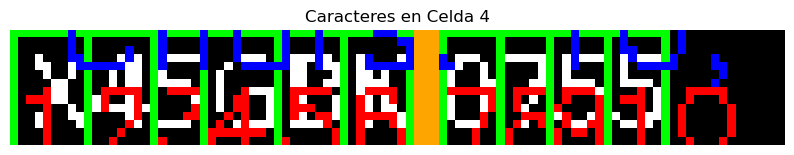

   Celda 4: 10 caracteres, 2 palabras


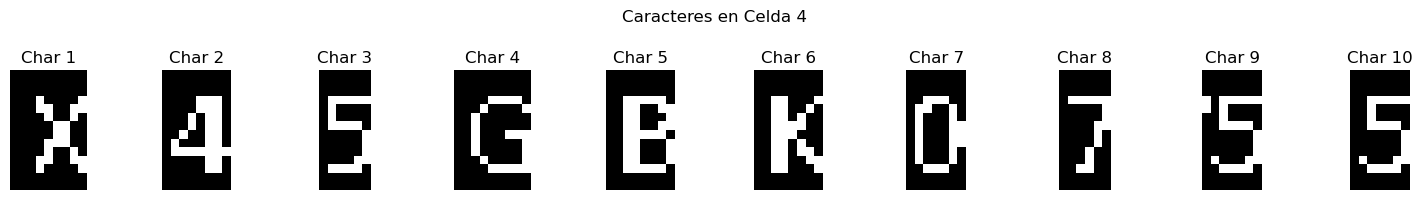


   Procesando Celda 5:


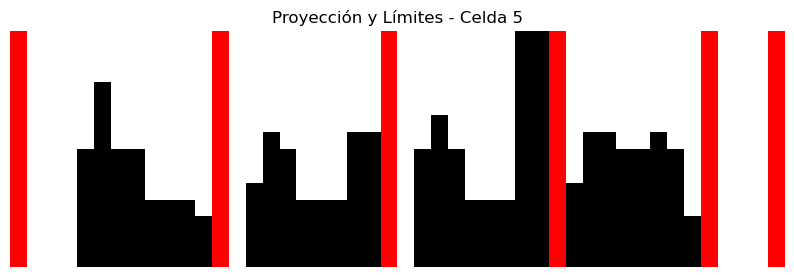

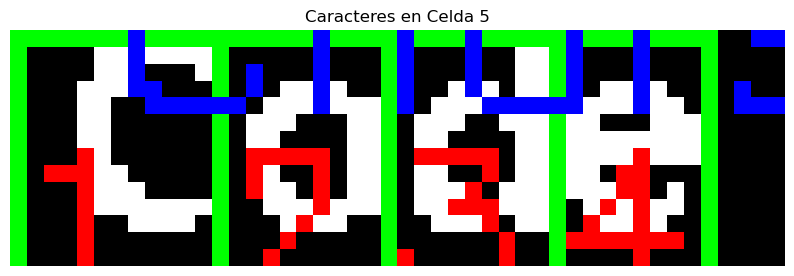

   Celda 5: 4 caracteres, 1 palabras


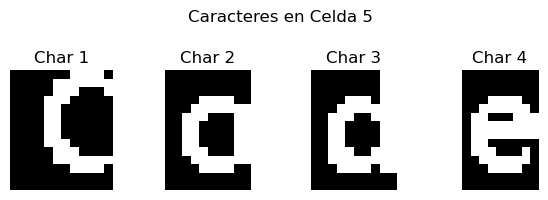


   Procesando Celda 6:


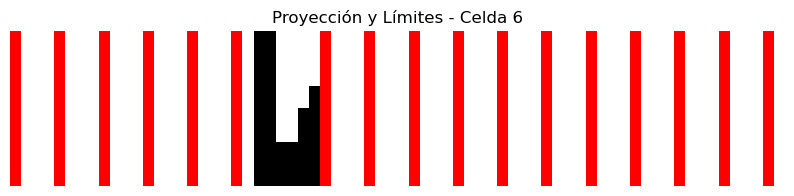

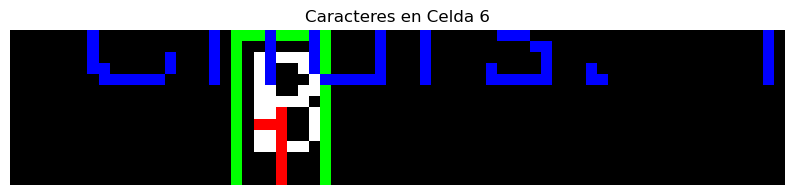

   Celda 6: 1 caracteres, 1 palabras


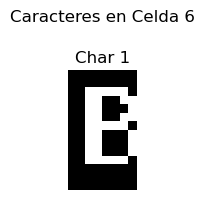


   Procesando Celda 7:


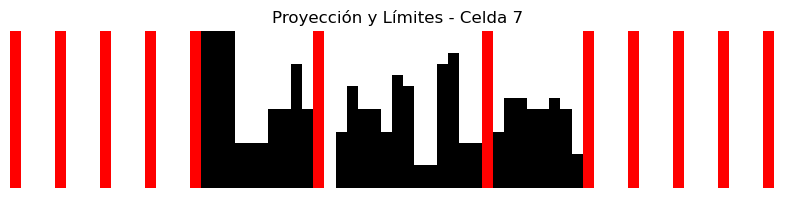

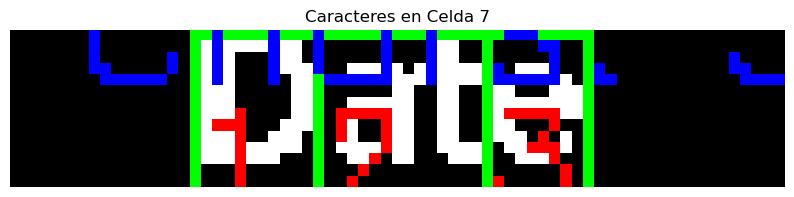

   Celda 7: 3 caracteres, 1 palabras


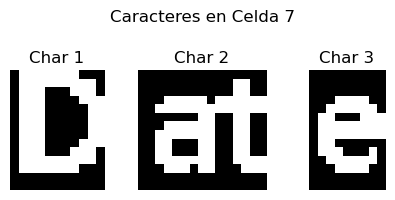


   Procesando Celda 8:


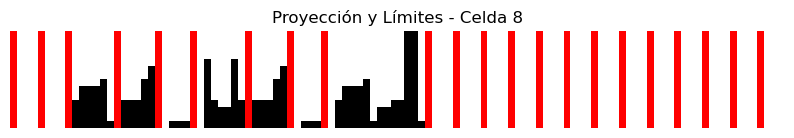

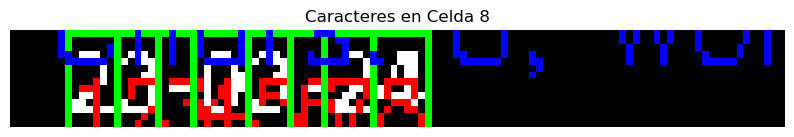

   Celda 8: 8 caracteres, 1 palabras


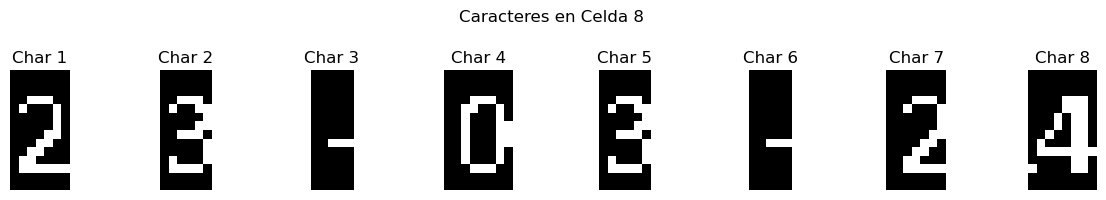

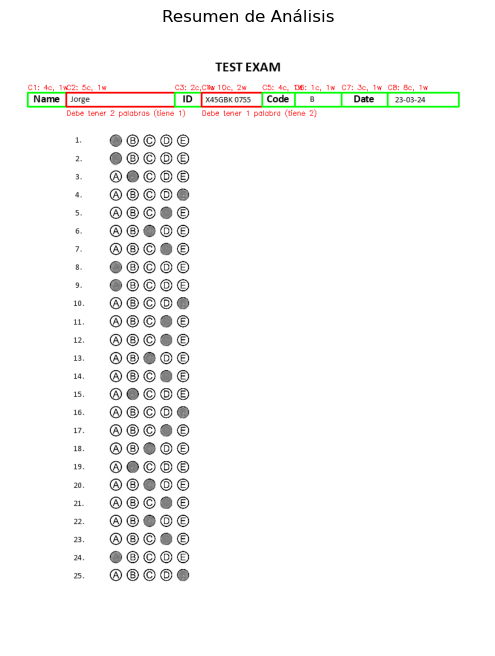


Resumen de validación:
Celda 1: ✓ VÁLIDA
Celda 2: ✗ INVÁLIDA - Debe tener 2 palabras (tiene 1)
Celda 3: ✓ VÁLIDA
Celda 4: ✗ INVÁLIDA - Debe tener 1 palabra (tiene 2)
Celda 5: ✓ VÁLIDA
Celda 6: ✓ VÁLIDA
Celda 7: ✓ VÁLIDA
Celda 8: ✓ VÁLIDA

Procesamiento completado con éxito.


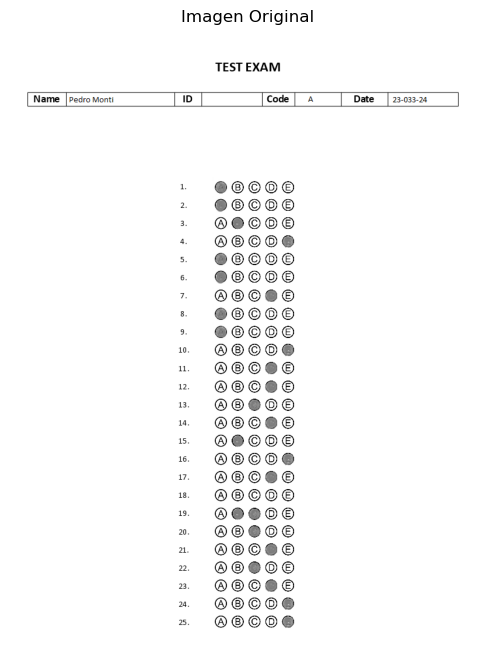

1. Obteniendo imagen binaria...


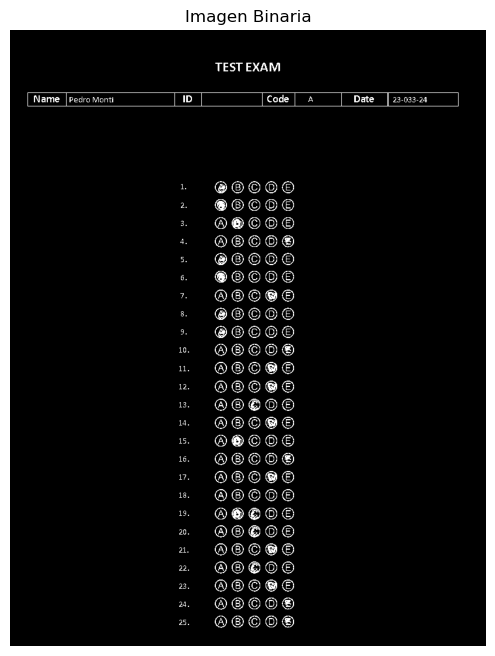

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


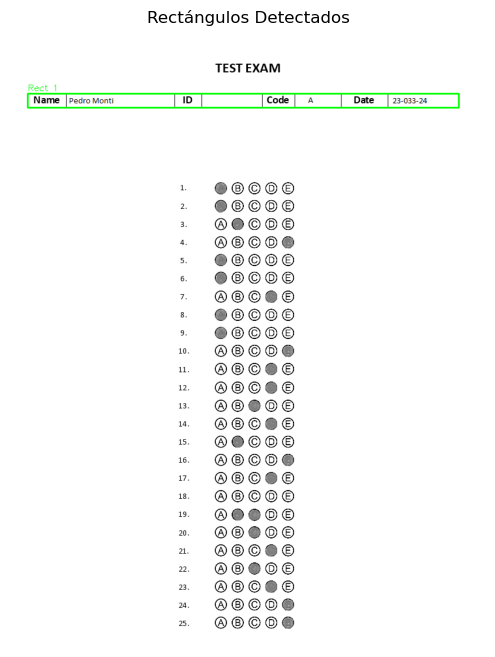

3. Dividiendo el rectángulo en celdas...


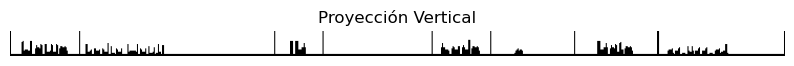

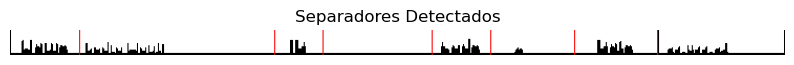

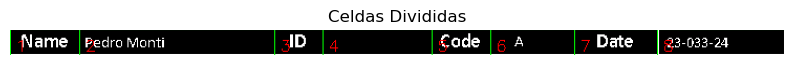

   Se dividió el rectángulo en 8 celdas


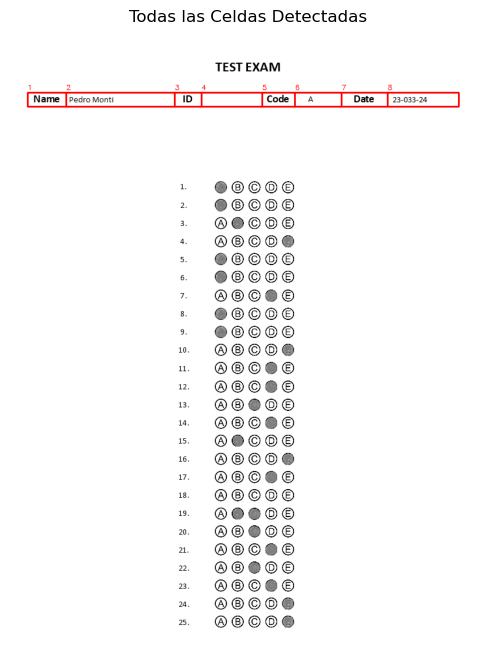

Mostrando celdas individuales:


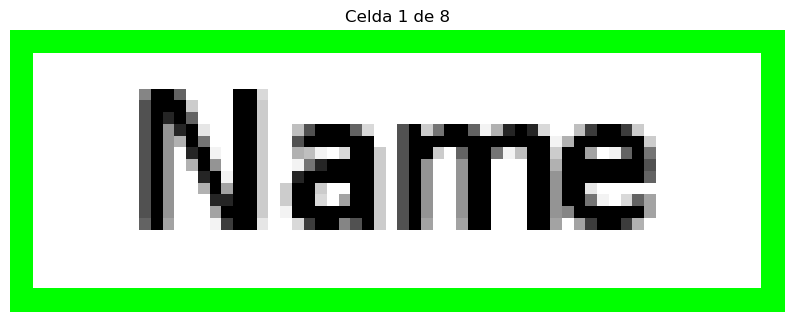

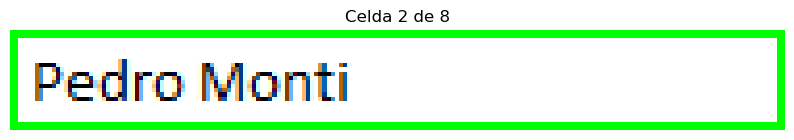

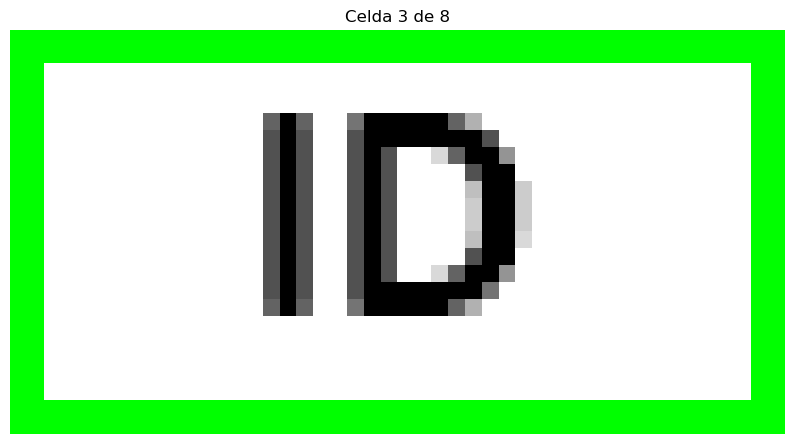

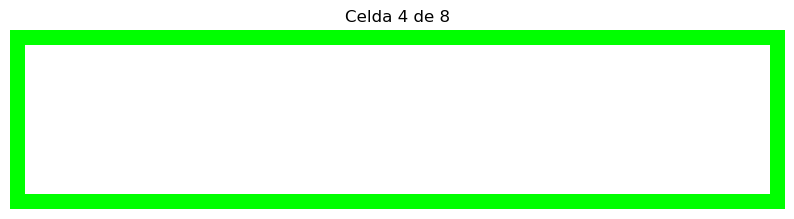

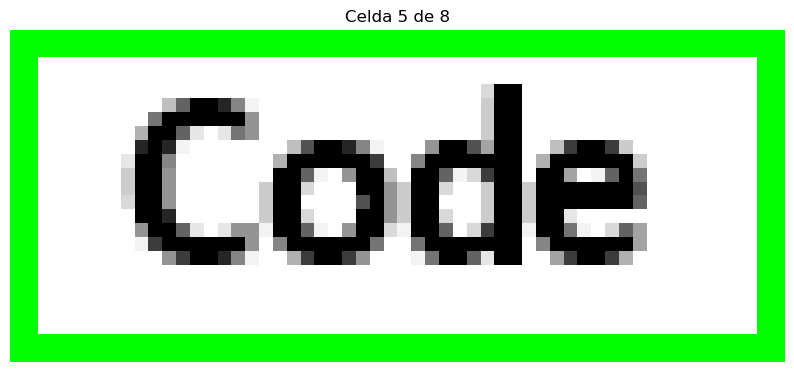

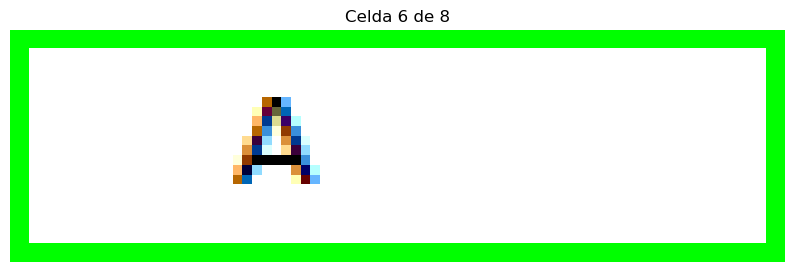

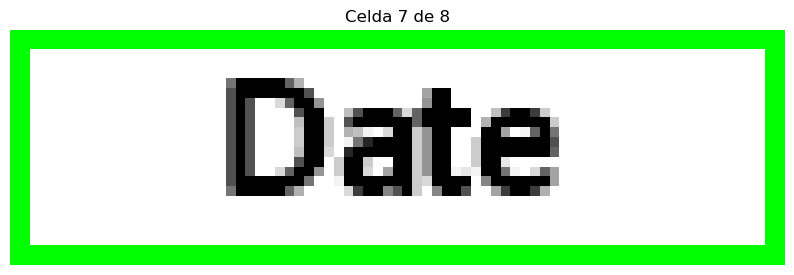

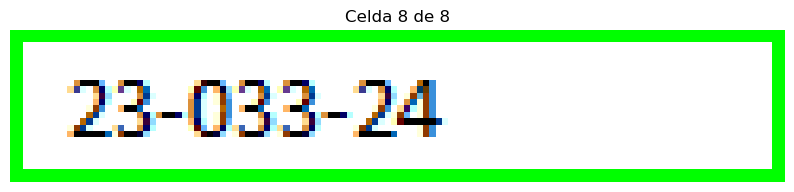

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


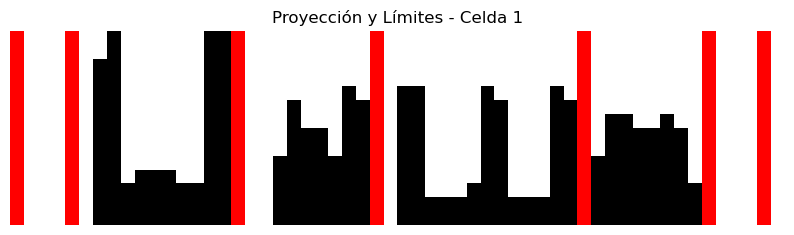

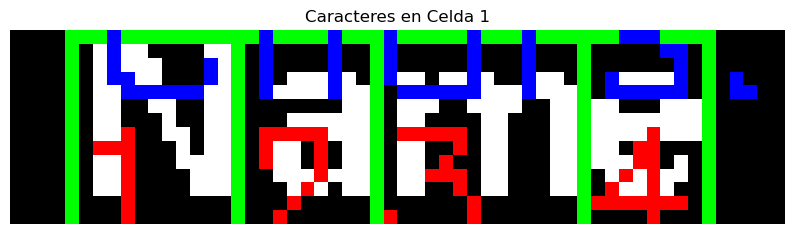

   Celda 1: 4 caracteres, 1 palabras


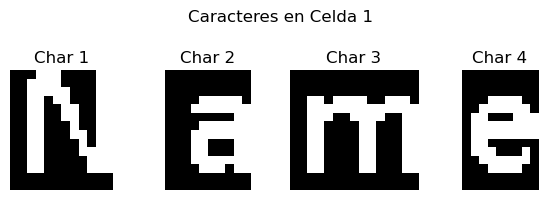


   Procesando Celda 2:


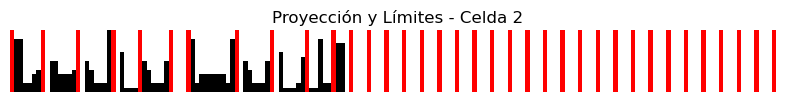

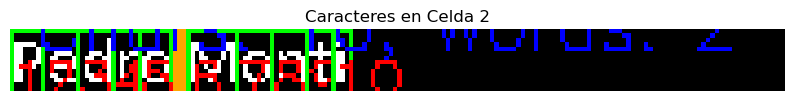

   Celda 2: 10 caracteres, 2 palabras


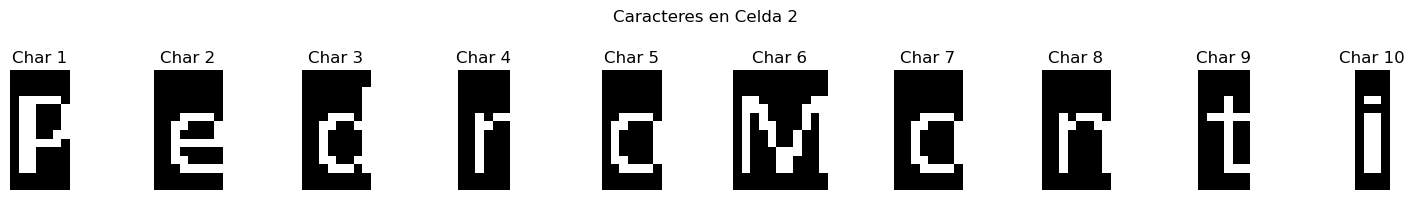


   Procesando Celda 3:


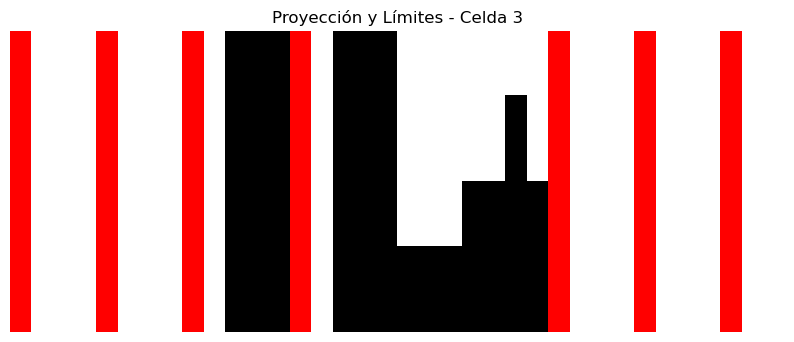

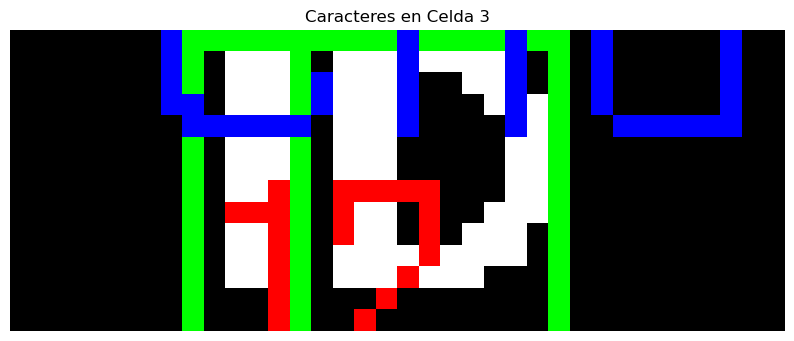

   Celda 3: 2 caracteres, 1 palabras


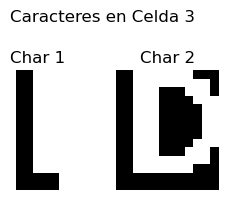


   Procesando Celda 4:


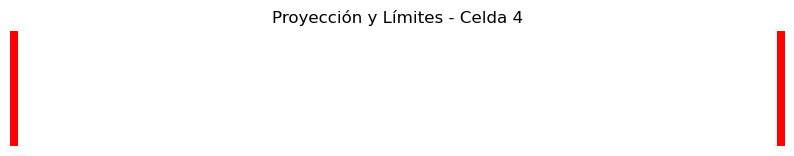

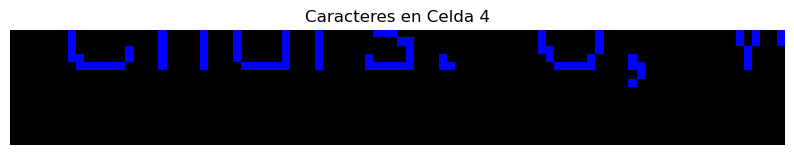

   Celda 4: 0 caracteres, 0 palabras

   Procesando Celda 5:


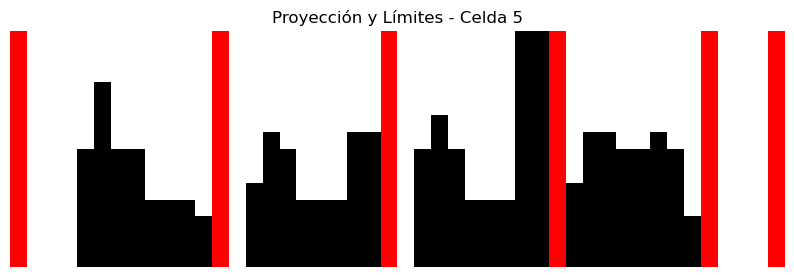

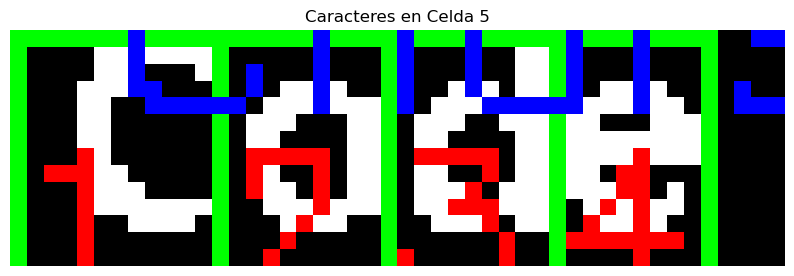

   Celda 5: 4 caracteres, 1 palabras


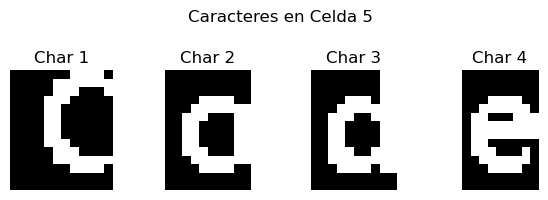


   Procesando Celda 6:


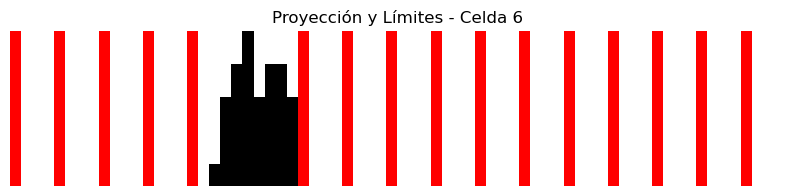

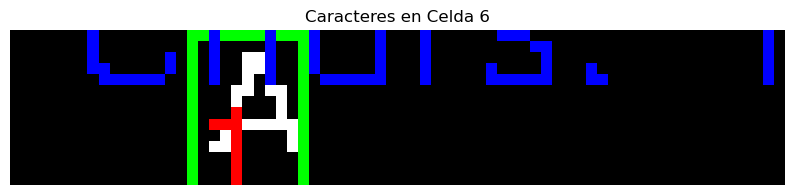

   Celda 6: 1 caracteres, 1 palabras


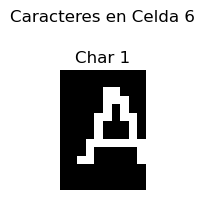


   Procesando Celda 7:


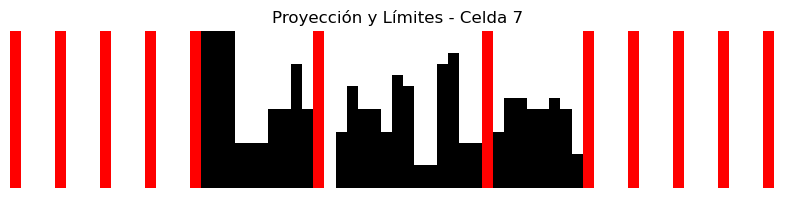

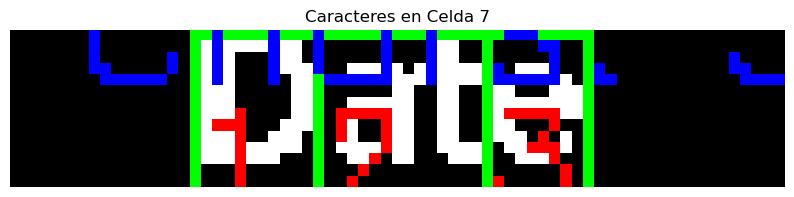

   Celda 7: 3 caracteres, 1 palabras


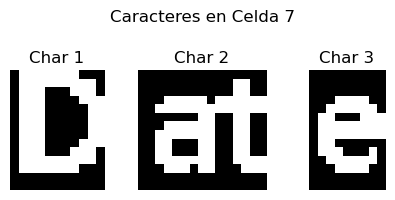


   Procesando Celda 8:


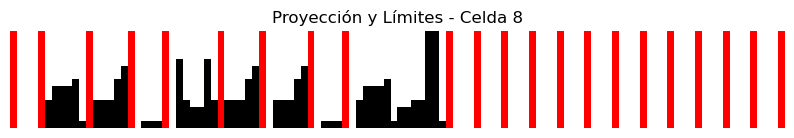

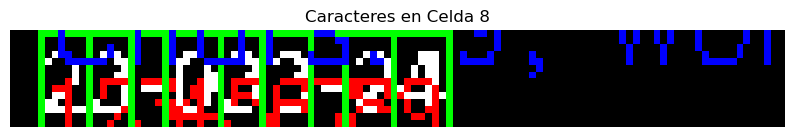

   Celda 8: 9 caracteres, 1 palabras


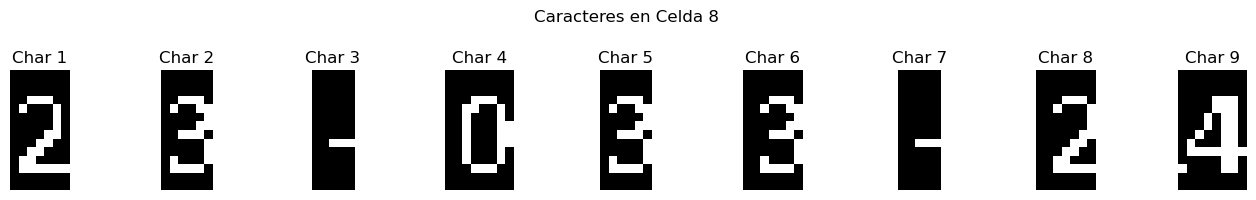

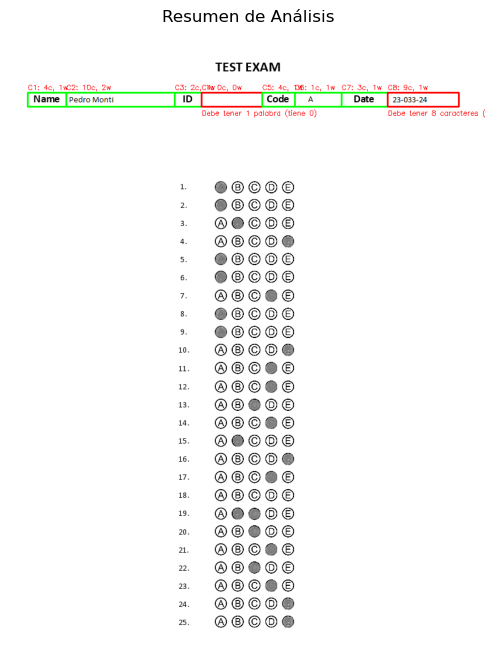


Resumen de validación:
Celda 1: ✓ VÁLIDA
Celda 2: ✓ VÁLIDA
Celda 3: ✓ VÁLIDA
Celda 4: ✗ INVÁLIDA - Debe tener 1 palabra (tiene 0)
Celda 5: ✓ VÁLIDA
Celda 6: ✓ VÁLIDA
Celda 7: ✓ VÁLIDA
Celda 8: ✗ INVÁLIDA - Debe tener 8 caracteres (tiene 9)

Procesamiento completado con éxito.


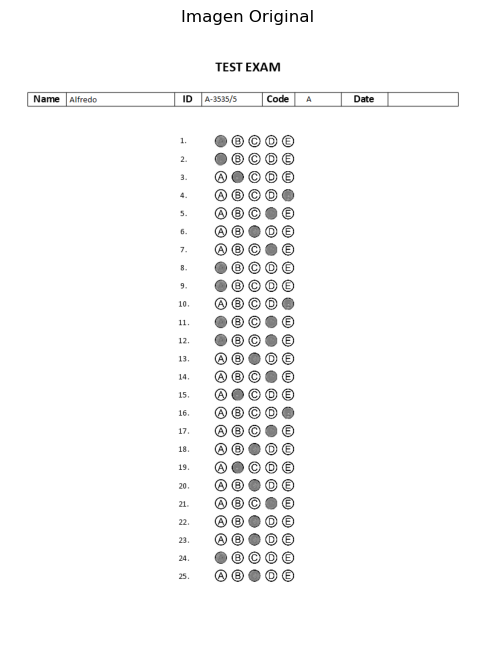

1. Obteniendo imagen binaria...


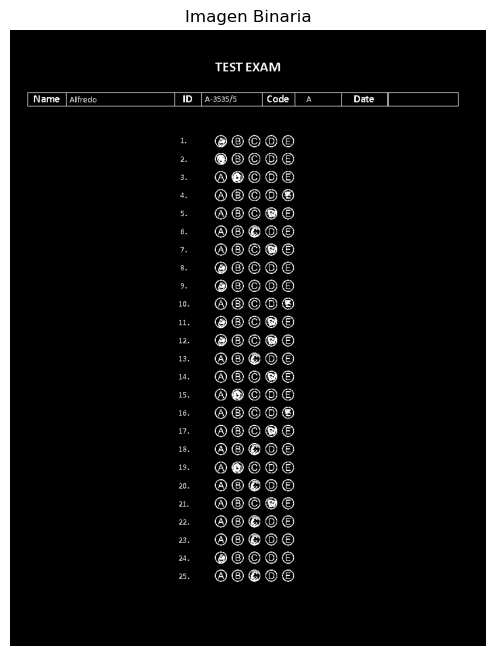

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


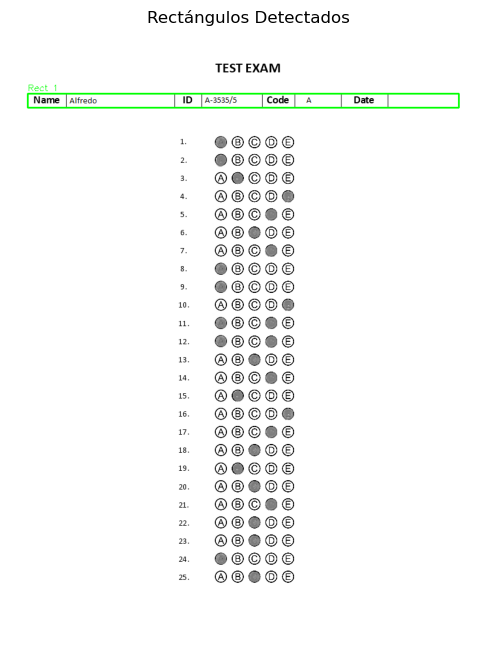

3. Dividiendo el rectángulo en celdas...


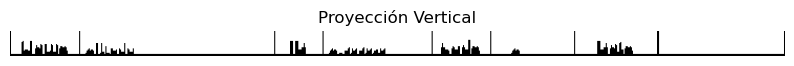

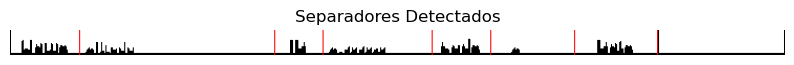

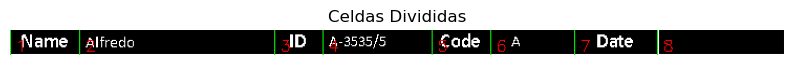

   Se dividió el rectángulo en 8 celdas


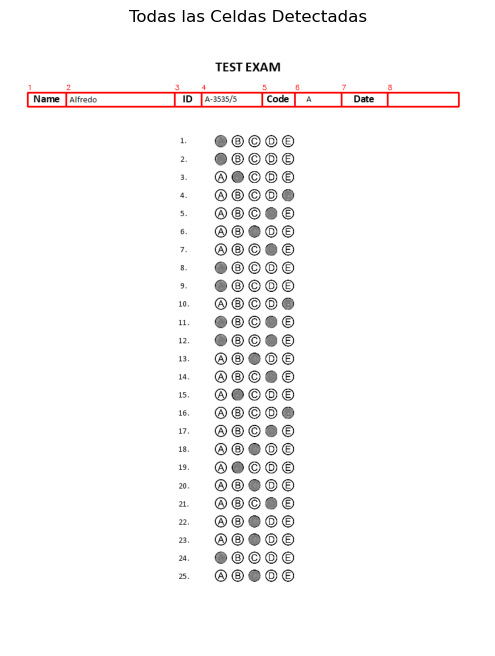

Mostrando celdas individuales:


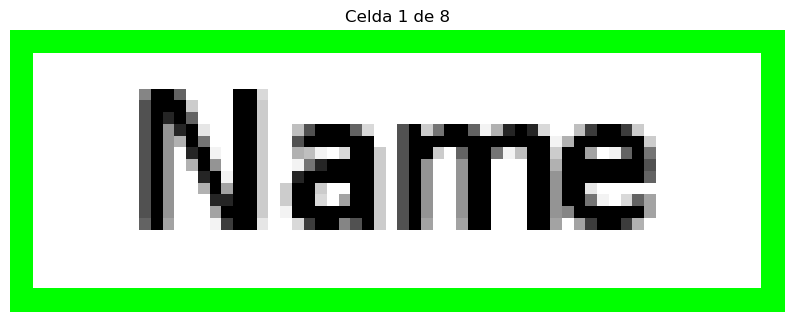

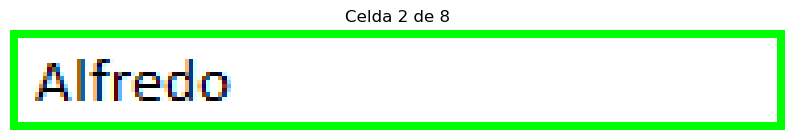

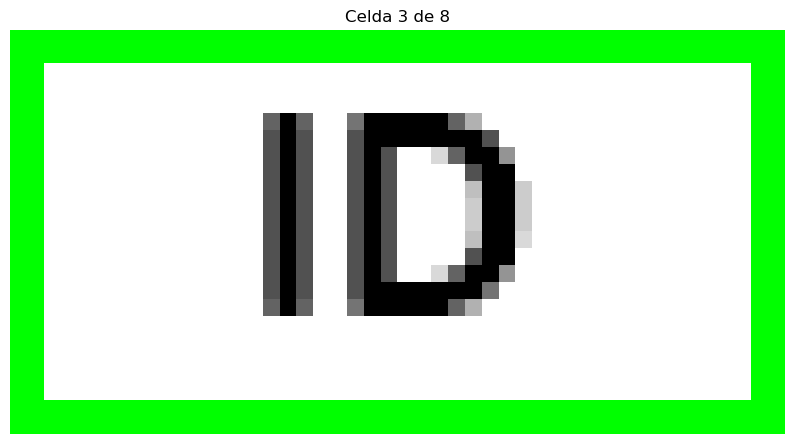

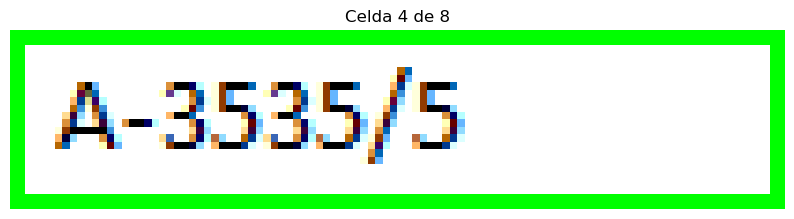

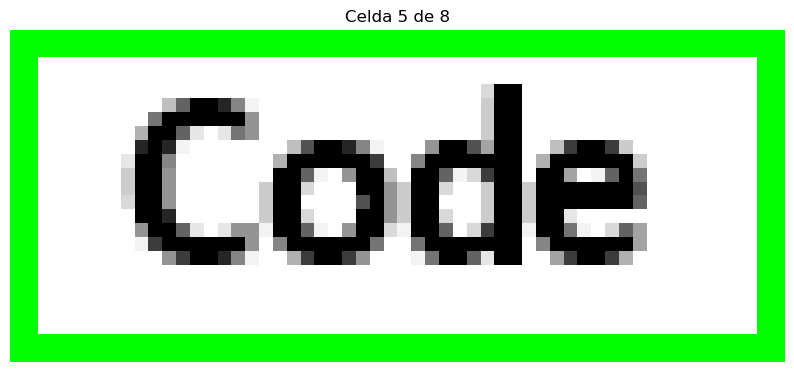

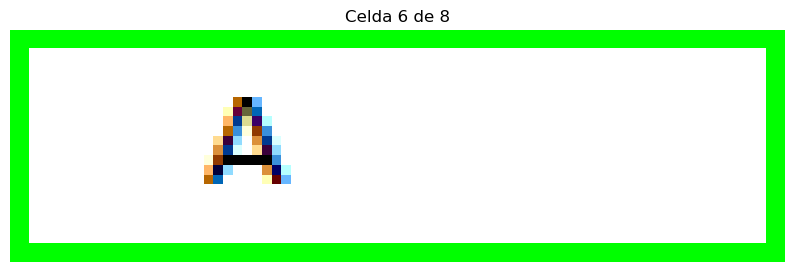

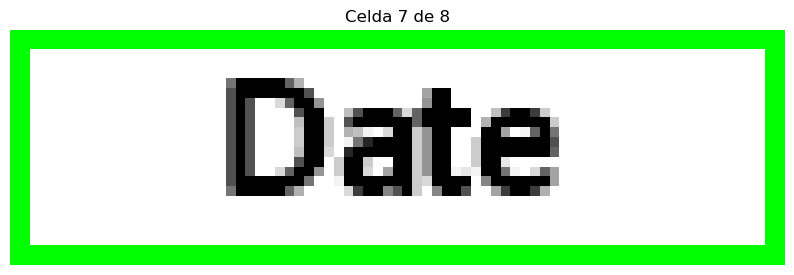

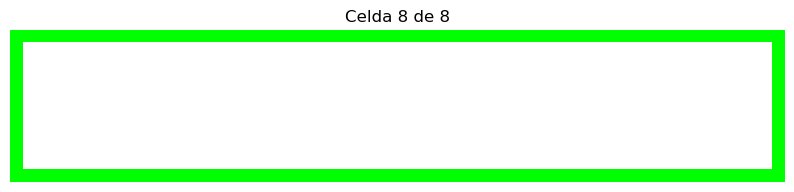

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


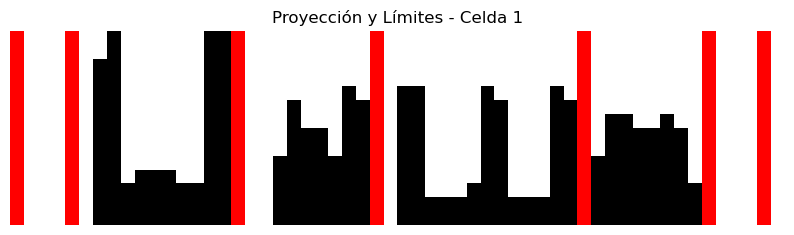

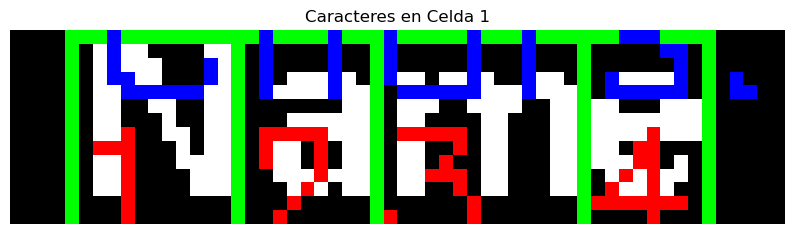

   Celda 1: 4 caracteres, 1 palabras


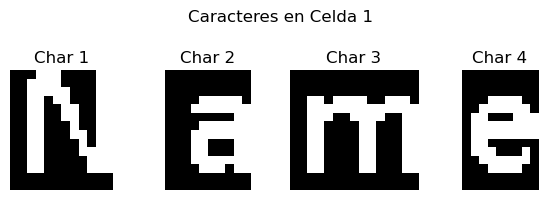


   Procesando Celda 2:


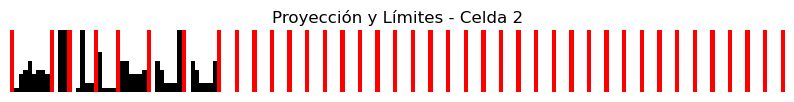

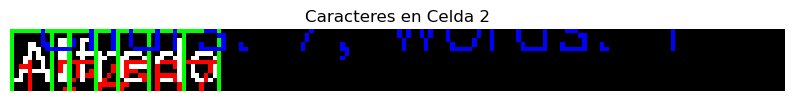

   Celda 2: 7 caracteres, 1 palabras


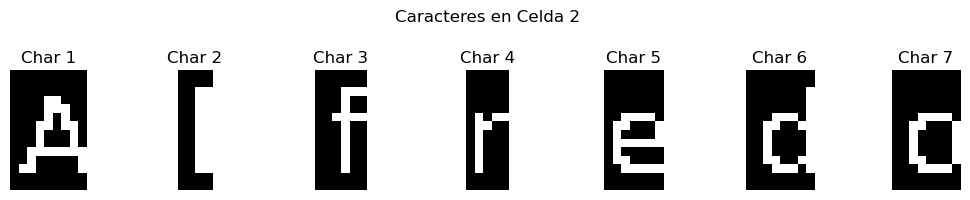


   Procesando Celda 3:


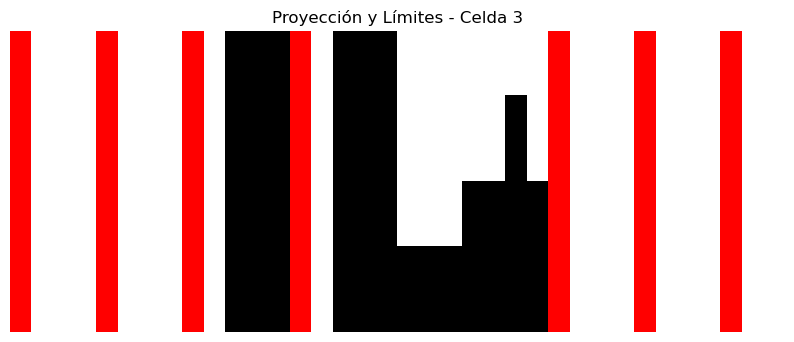

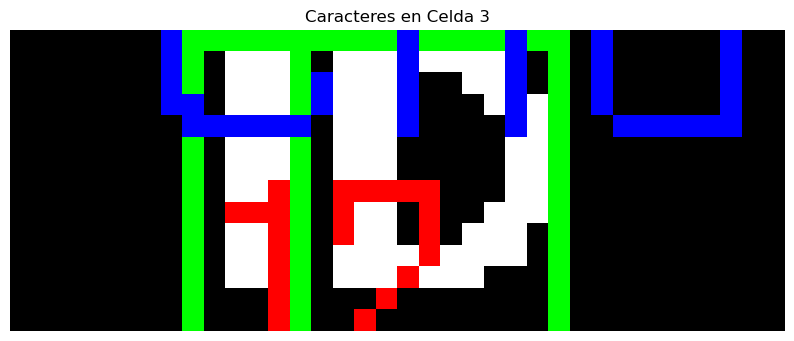

   Celda 3: 2 caracteres, 1 palabras


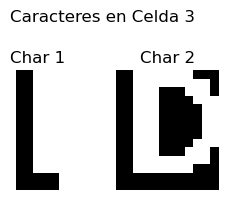


   Procesando Celda 4:


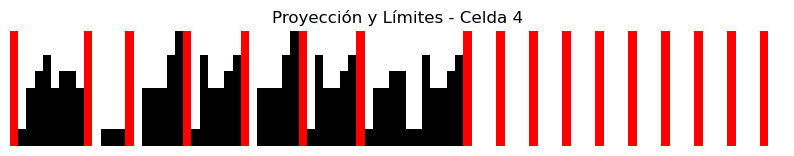

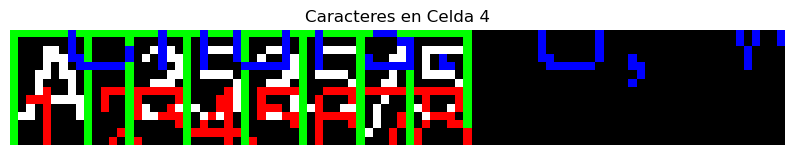

   Celda 4: 8 caracteres, 1 palabras


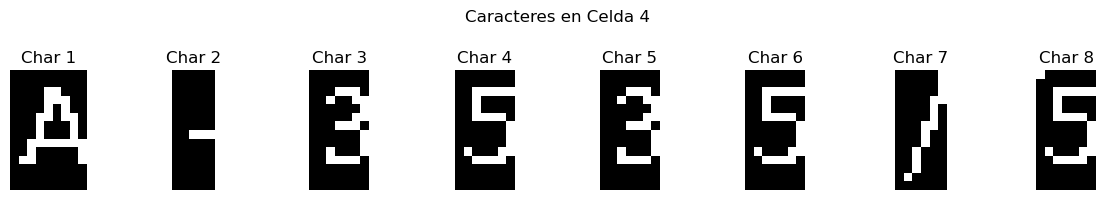


   Procesando Celda 5:


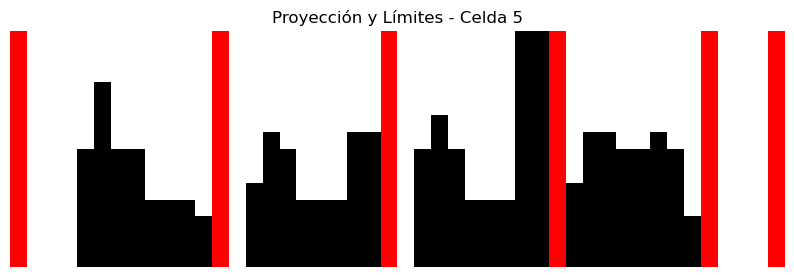

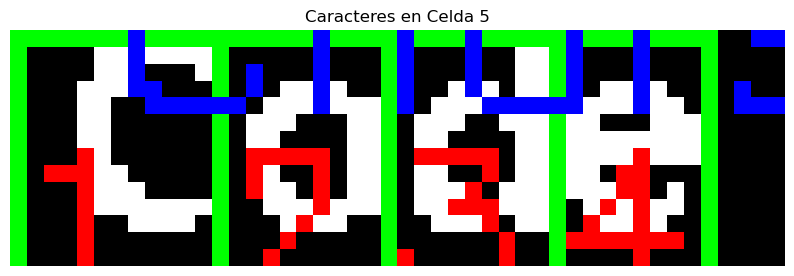

   Celda 5: 4 caracteres, 1 palabras


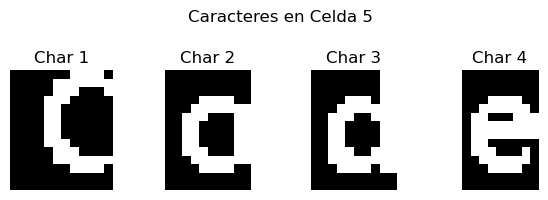


   Procesando Celda 6:


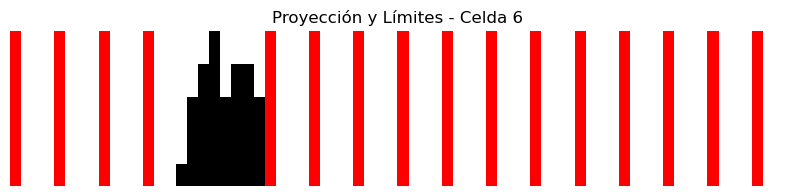

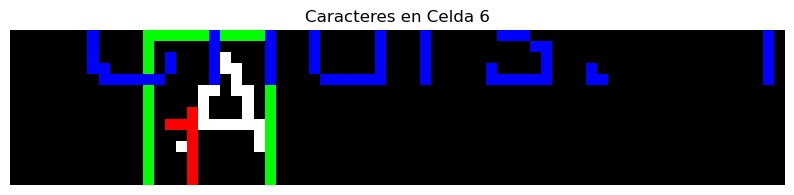

   Celda 6: 1 caracteres, 1 palabras


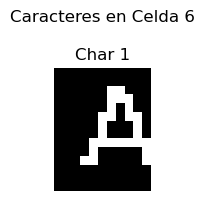


   Procesando Celda 7:


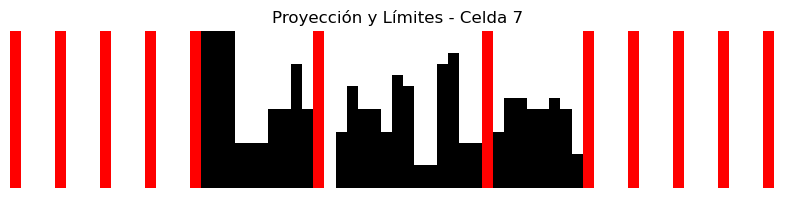

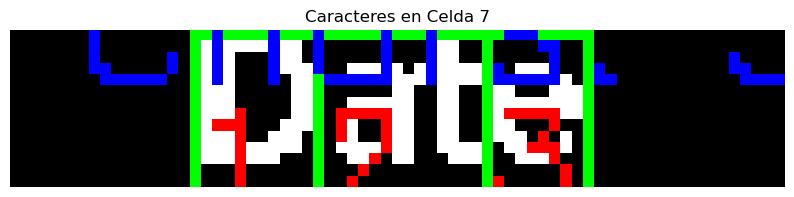

   Celda 7: 3 caracteres, 1 palabras


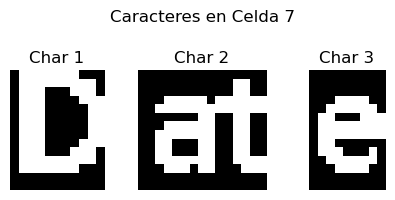


   Procesando Celda 8:


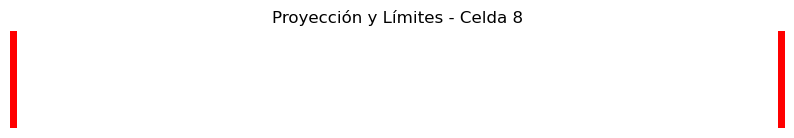

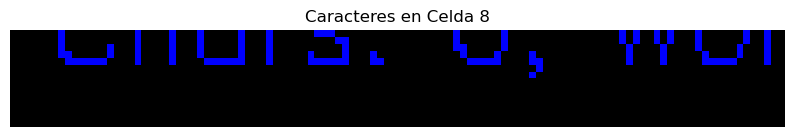

   Celda 8: 0 caracteres, 0 palabras


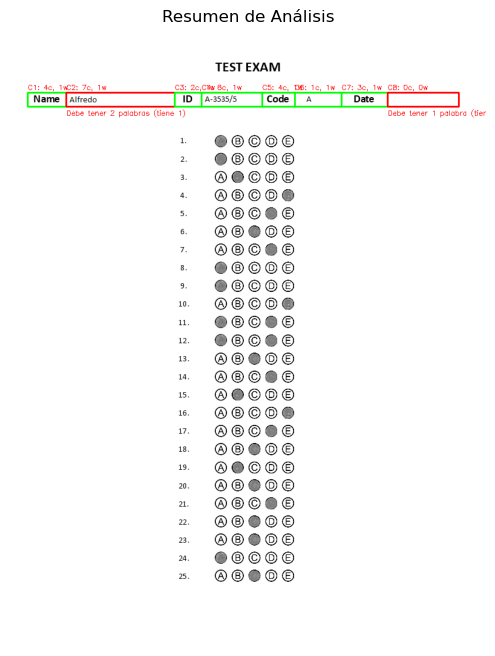


Resumen de validación:
Celda 1: ✓ VÁLIDA
Celda 2: ✗ INVÁLIDA - Debe tener 2 palabras (tiene 1)
Celda 3: ✓ VÁLIDA
Celda 4: ✓ VÁLIDA
Celda 5: ✓ VÁLIDA
Celda 6: ✓ VÁLIDA
Celda 7: ✓ VÁLIDA
Celda 8: ✗ INVÁLIDA - Debe tener 1 palabra (tiene 0)

Procesamiento completado con éxito.


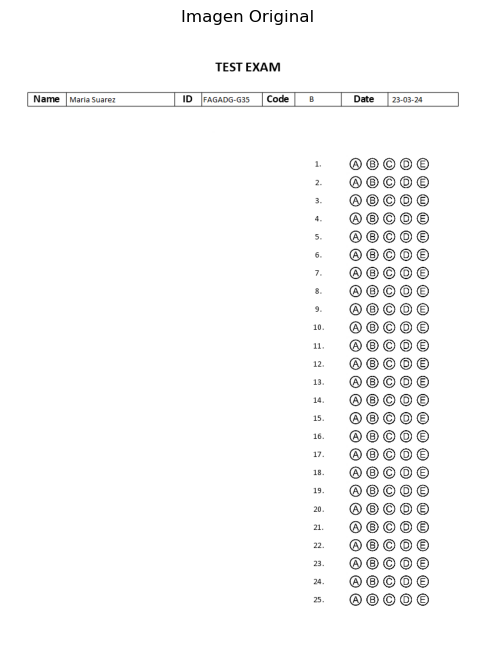

1. Obteniendo imagen binaria...


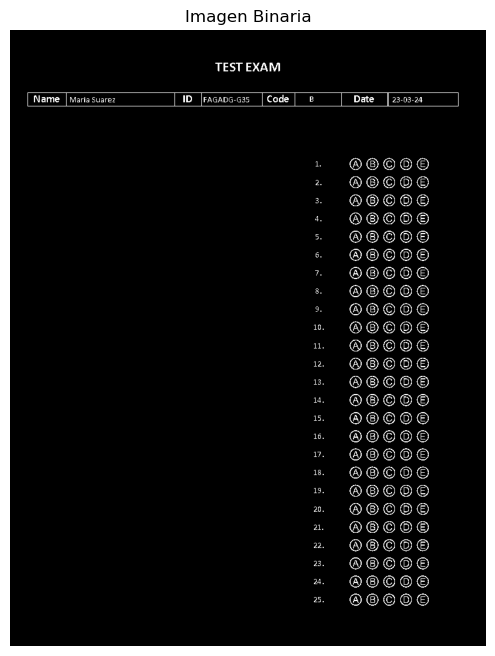

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


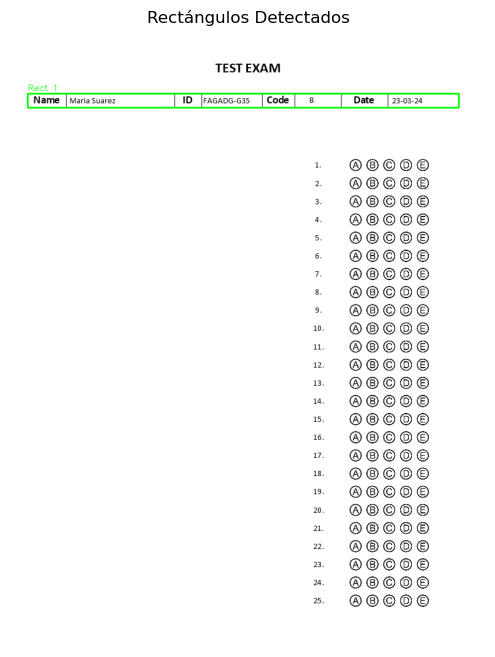

3. Dividiendo el rectángulo en celdas...


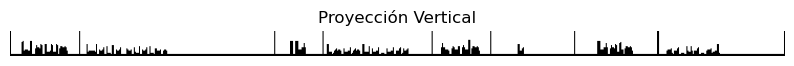

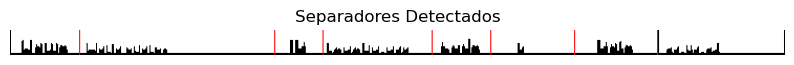

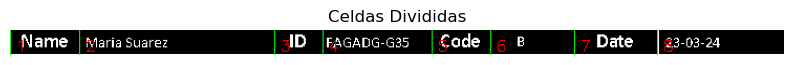

   Se dividió el rectángulo en 8 celdas


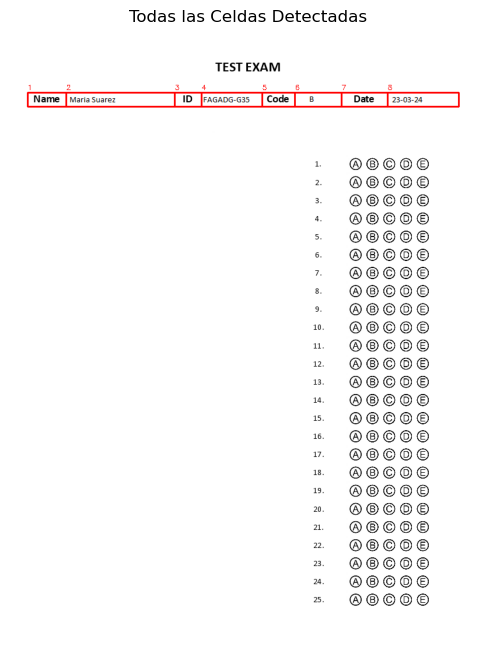

Mostrando celdas individuales:


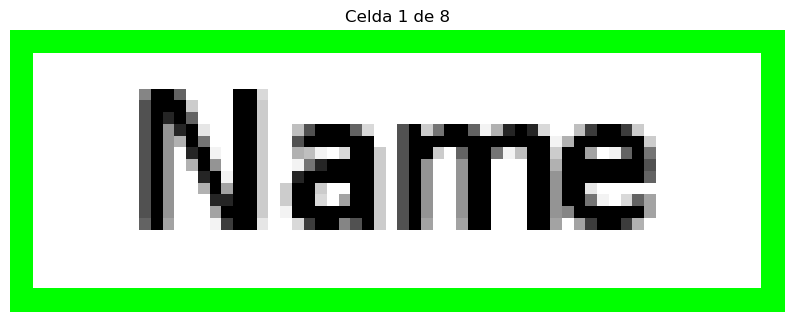

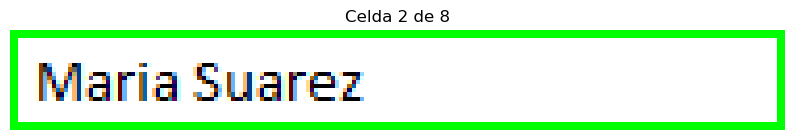

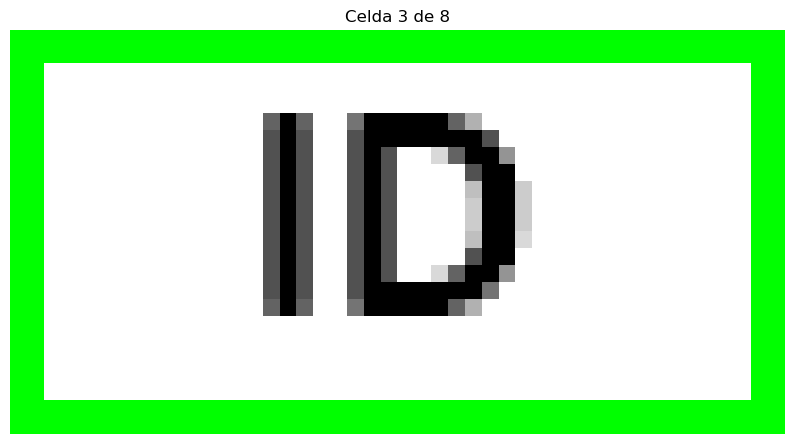

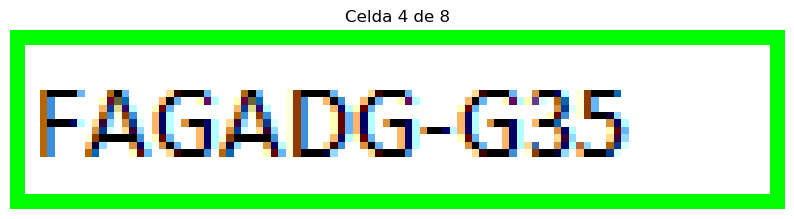

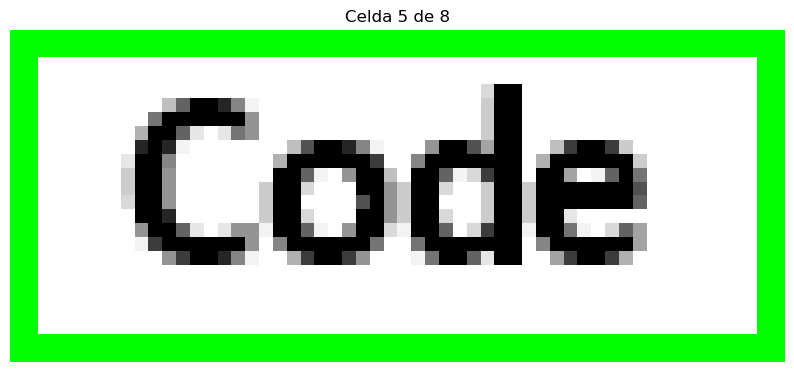

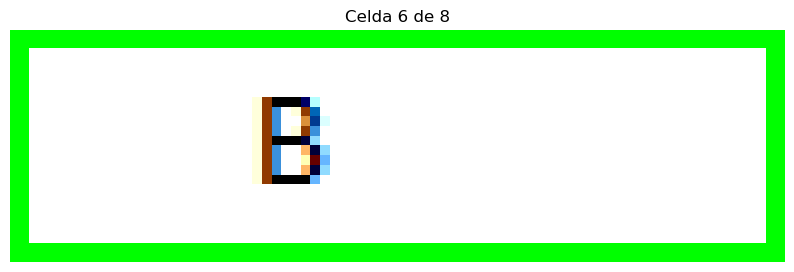

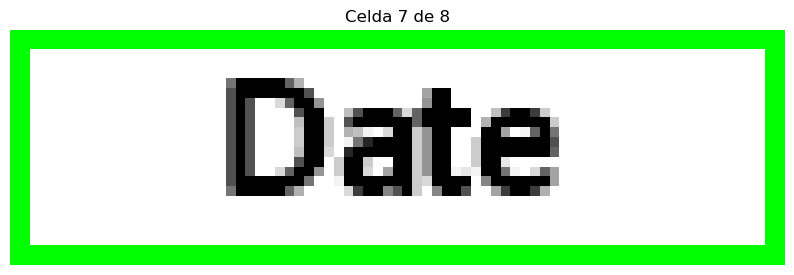

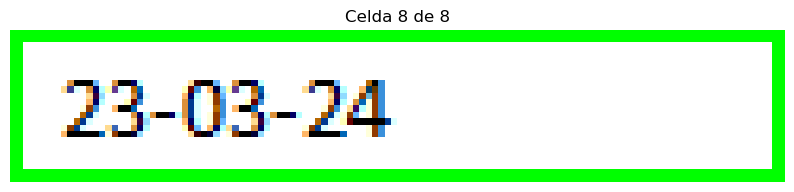

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


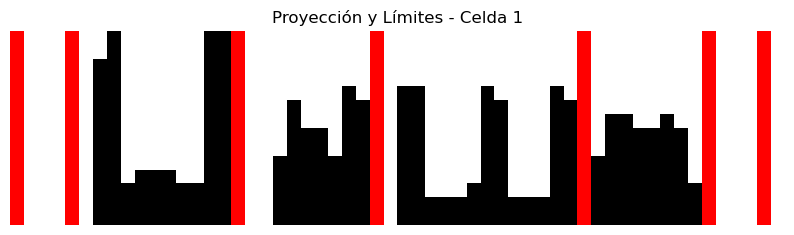

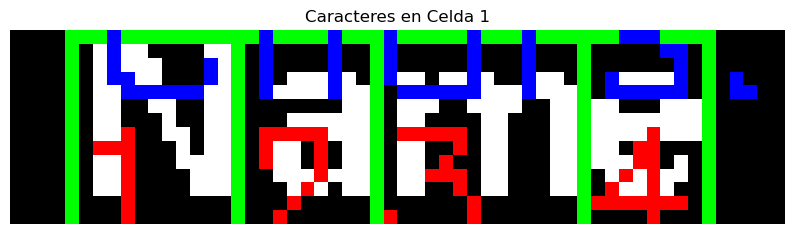

   Celda 1: 4 caracteres, 1 palabras


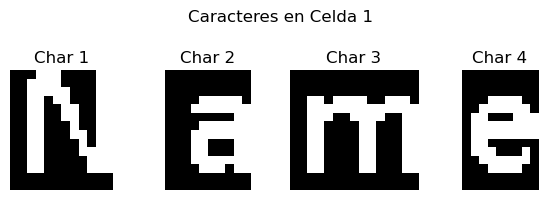


   Procesando Celda 2:


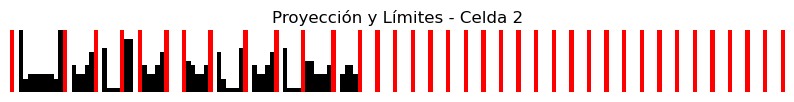

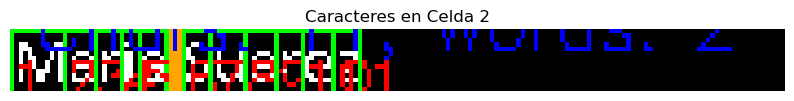

   Celda 2: 11 caracteres, 2 palabras


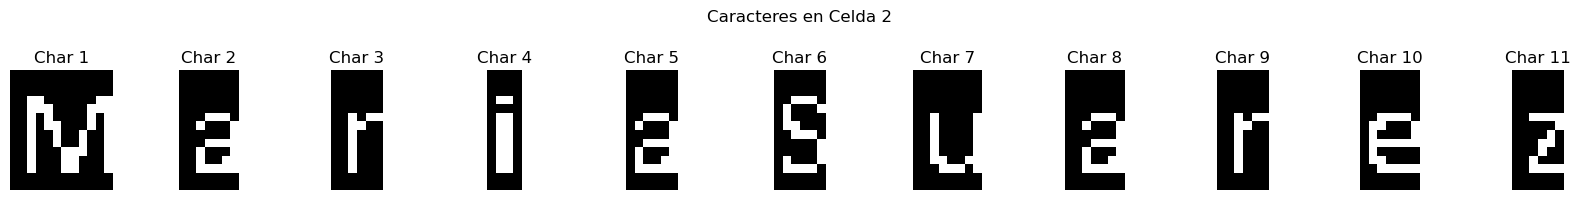


   Procesando Celda 3:


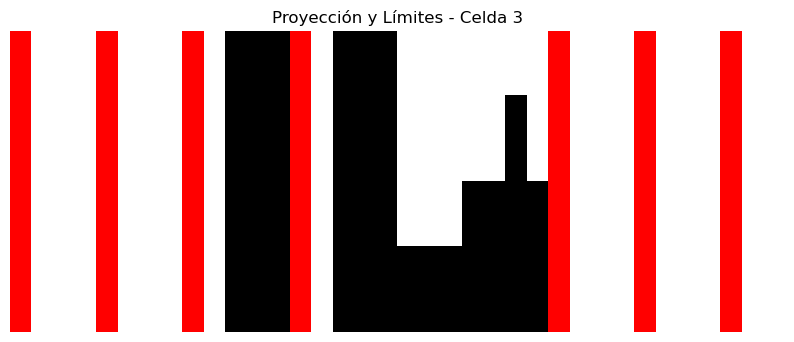

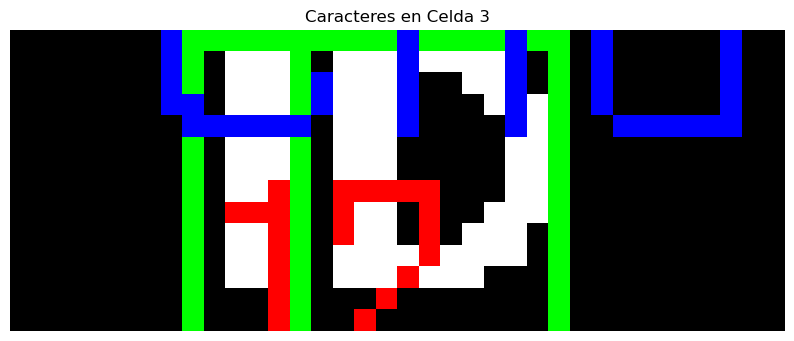

   Celda 3: 2 caracteres, 1 palabras


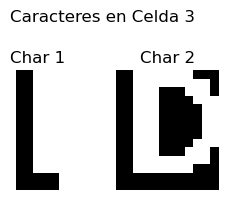


   Procesando Celda 4:


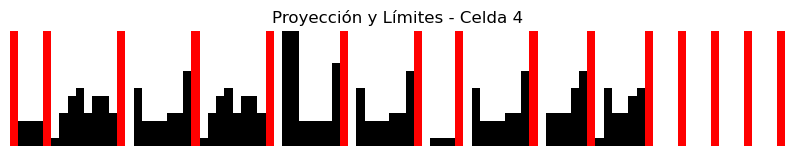

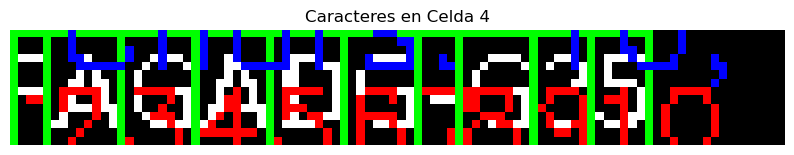

   Celda 4: 10 caracteres, 1 palabras


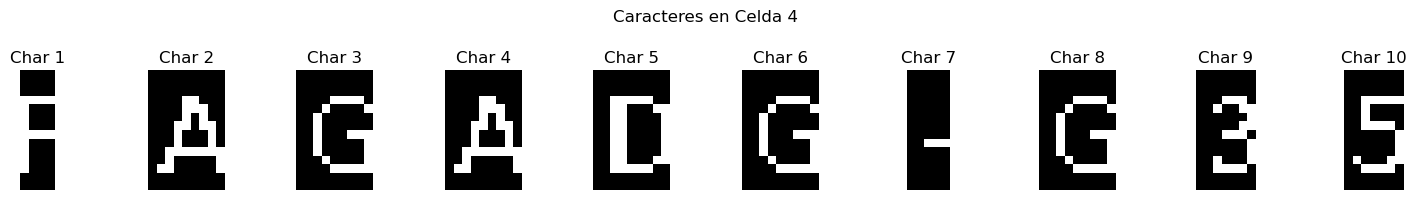


   Procesando Celda 5:


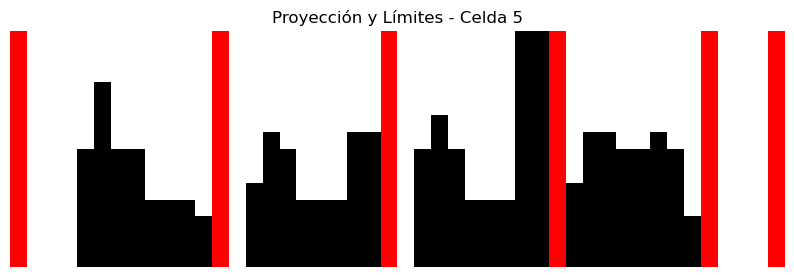

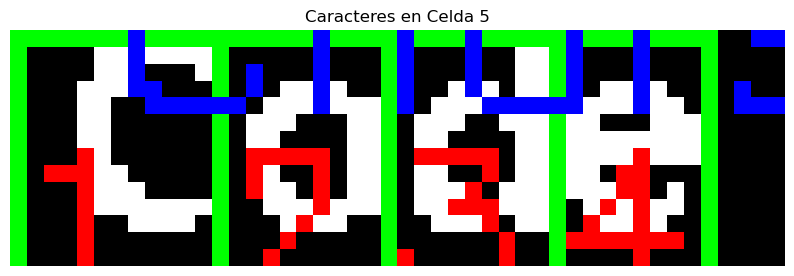

   Celda 5: 4 caracteres, 1 palabras


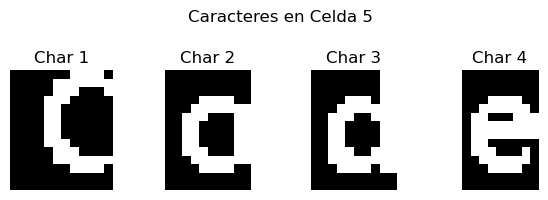


   Procesando Celda 6:


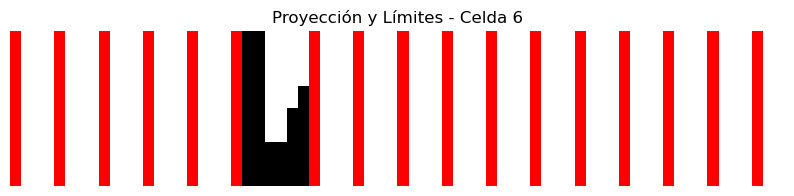

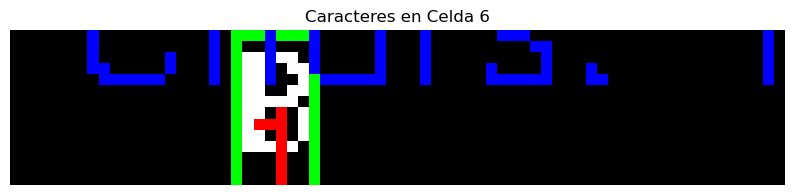

   Celda 6: 1 caracteres, 1 palabras


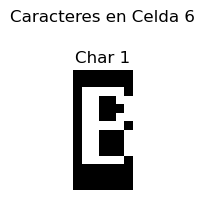


   Procesando Celda 7:


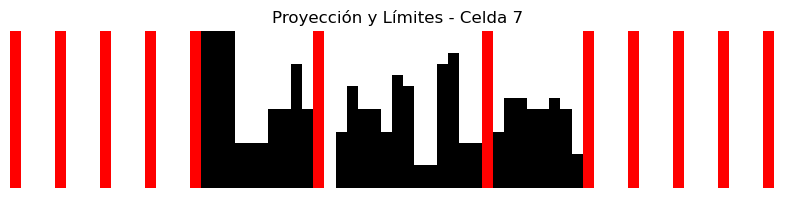

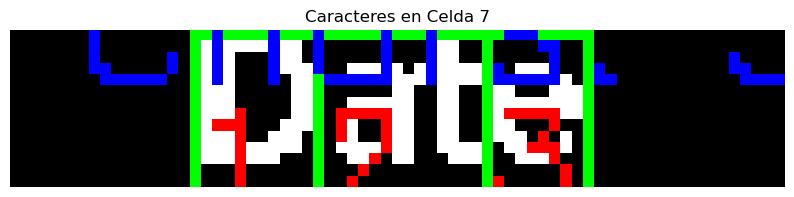

   Celda 7: 3 caracteres, 1 palabras


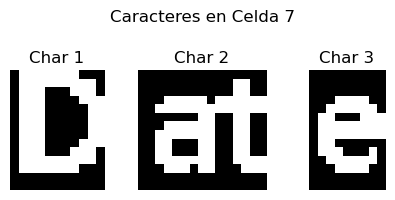


   Procesando Celda 8:


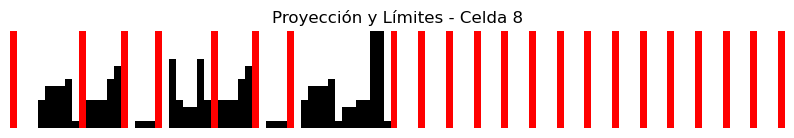

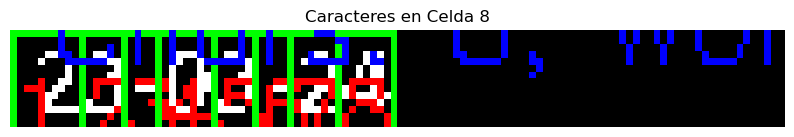

   Celda 8: 8 caracteres, 1 palabras


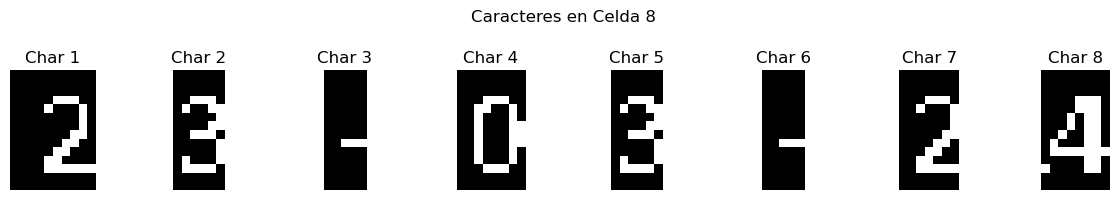

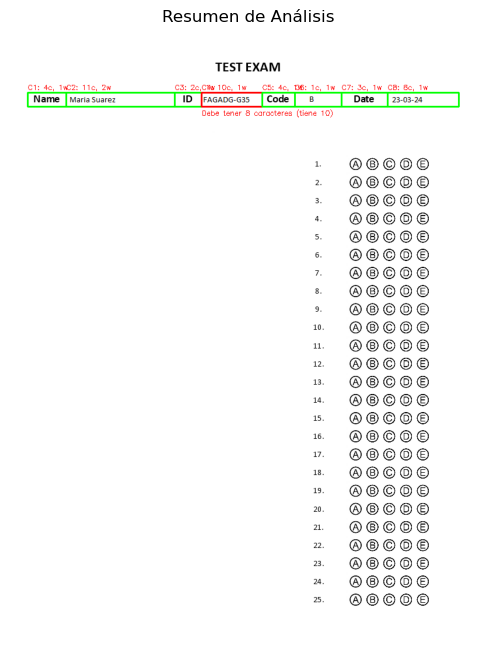


Resumen de validación:
Celda 1: ✓ VÁLIDA
Celda 2: ✓ VÁLIDA
Celda 3: ✓ VÁLIDA
Celda 4: ✗ INVÁLIDA - Debe tener 8 caracteres (tiene 10)
Celda 5: ✓ VÁLIDA
Celda 6: ✓ VÁLIDA
Celda 7: ✓ VÁLIDA
Celda 8: ✓ VÁLIDA

Procesamiento completado con éxito.


In [54]:
datos_ejercicio2 = {}
for i in range(1,6):
    ruta_imagen = r"./multiple_choice_"+str(i)+".png"
    datos_ejercicio2[f"examen{i}"] = ejercicio2(ruta_imagen)


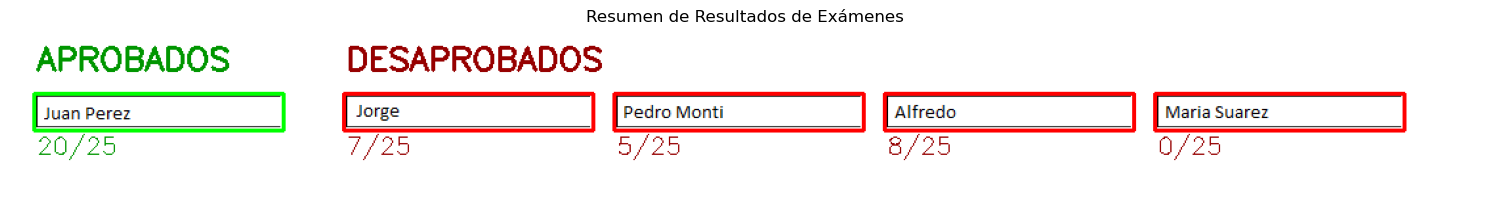

Imagen de resumen guardada como 'resumen_examenes.png'


In [55]:
def generar_imagen_resumen(datos_ejercicio1, datos_ejercicio2):
    """
    Genera una imagen resumen con los nombres de los estudiantes, 
    mostrando aprobados (verde) a la izquierda y desaprobados (rojo) a la derecha.
    
    Args:
        datos_ejercicio1: Diccionario con los puntajes de cada examen
        datos_ejercicio2: Diccionario con las coordenadas de las celdas de cada examen
    """
    # Listas para almacenar información de aprobados y desaprobados
    aprobados = []
    desaprobados = []
    
    # Procesar cada examen
    for i in range(1, 6):
        # Cargar la imagen original
        ruta_imagen = f"./multiple_choice_{i}.png"
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: No se pudo cargar la imagen {ruta_imagen}")
            continue
        
        # Obtener coordenadas de la celda del nombre (celda 2)
        if f"examen{i}" in datos_ejercicio2 and "celdas" in datos_ejercicio2[f"examen{i}"]:
            celda_coords = datos_ejercicio2[f"examen{i}"]["celdas"][1]  # Índice 1 corresponde a la celda 2
            
            # Extraer la región del nombre
            x, y, w, h = celda_coords
            nombre_img = imagen[y:y+h, x:x+w].copy()
            
            # Verificar si el examen está aprobado (puntaje >= 20)
            puntaje = datos_ejercicio1[f"examen{i}"]
            aprobado = puntaje >= 20
            
            # Almacenar la información
            info = {
                'imagen': nombre_img,
                'puntaje': puntaje
            }
            
            if aprobado:
                aprobados.append(info)
            else:
                desaprobados.append(info)
        else:
            print(f"Error: No se encontraron datos para el examen {i}")
    
    # Calcular dimensiones para la imagen de resumen
    max_height = 0
    total_width_aprobados = 0
    total_width_desaprobados = 0
    
    # Calcular dimensiones para aprobados
    for info in aprobados:
        h, w = info['imagen'].shape[:2]
        max_height = max(max_height, h + 100)  # Espacio adicional para texto
        total_width_aprobados += w + 20  # Espacio entre imágenes
    
    # Calcular dimensiones para desaprobados
    for info in desaprobados:
        h, w = info['imagen'].shape[:2]
        max_height = max(max_height, h + 100)  # Espacio adicional para texto
        total_width_desaprobados += w + 20  # Espacio entre imágenes
    
    # Ajustar anchos totales
    if aprobados:
        total_width_aprobados += 20  # Margen adicional
    if desaprobados:
        total_width_desaprobados += 20  # Margen adicional
    
    # Crear imagen de resumen
    total_width = total_width_aprobados + total_width_desaprobados + 50  # Separación entre secciones
    resumen_img = np.ones((max_height, total_width, 3), dtype=np.uint8) * 255
    
    # Título para la sección de aprobados
    if aprobados:
        cv2.putText(resumen_img, "APROBADOS", (20, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 150, 0), 2)
    
    # Título para la sección de desaprobados
    if desaprobados:
        x_desaprobados = total_width_aprobados + 30
        cv2.putText(resumen_img, "DESAPROBADOS", (x_desaprobados, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 150), 2)
    
    # Colocar imágenes de nombres de aprobados
    x_offset = 20
    for info in aprobados:
        nombre_img = info['imagen']
        h, w = nombre_img.shape[:2]
        
        # Convertir a color si es necesario
        if len(nombre_img.shape) == 2:
            nombre_img = cv2.cvtColor(nombre_img, cv2.COLOR_GRAY2BGR)
        
        # Colocar la imagen del nombre
        y_offset = 50
        resumen_img[y_offset:y_offset+h, x_offset:x_offset+w] = nombre_img
        
        # Dibujar rectángulo verde alrededor del nombre
        cv2.rectangle(resumen_img, (x_offset-2, y_offset-2), 
                     (x_offset+w+2, y_offset+h+2), (0, 255, 0), 2)
        
        # Añadir texto con el puntaje
        texto = f"{info['puntaje']}/25"
        cv2.putText(resumen_img, texto, (x_offset, y_offset+h+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 150, 0), 1)
        
        # Actualizar el desplazamiento horizontal
        x_offset += w + 20
    
    # Colocar imágenes de nombres de desaprobados
    x_offset = total_width_aprobados + 30
    for info in desaprobados:
        nombre_img = info['imagen']
        h, w = nombre_img.shape[:2]
        
        # Convertir a color si es necesario
        if len(nombre_img.shape) == 2:
            nombre_img = cv2.cvtColor(nombre_img, cv2.COLOR_GRAY2BGR)
        
        # Colocar la imagen del nombre
        y_offset = 50
        resumen_img[y_offset:y_offset+h, x_offset:x_offset+w] = nombre_img
        
        # Dibujar rectángulo rojo alrededor del nombre
        cv2.rectangle(resumen_img, (x_offset-2, y_offset-2), 
                     (x_offset+w+2, y_offset+h+2), (0, 0, 255), 2)
        
        # Añadir texto con el puntaje
        texto = f"{info['puntaje']}/25"
        cv2.putText(resumen_img, texto, (x_offset, y_offset+h+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 150), 1)
        
        # Actualizar el desplazamiento horizontal
        x_offset += w + 20
    
    # Mostrar la imagen de resumen
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(resumen_img, cv2.COLOR_BGR2RGB))
    plt.title("Resumen de Resultados de Exámenes")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Guardar la imagen de resumen
    cv2.imwrite("resumen_examenes.png", resumen_img)
    print("Imagen de resumen guardada como 'resumen_examenes.png'")
    
    return resumen_img

# Ejecutar la función
resumen_img = generar_imagen_resumen(datos_ejercicio1, datos_ejercicio2)